In [1]:
# dependencies
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm 
import itertools
import scipy.stats as st
from scipy.stats import zscore
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
import numpy.random as npr
import ssm
import seaborn as sns
from ssm.util import one_hot, find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from datetime import date

from postProcessing import * #my module
from plottingfunctions import * #my module
from commonFunctions import * #my module
from myo2ReaChR_functions import * #my module

#to add to filenames as datestring
today = date.today()
datestring = today.strftime("%m%d%y")

npr.seed(0)

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "maroon",
    "slate",
    "light violet",
    "golden yellow",
    "bright pink",
    "bright turquoise"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

color_names = [
    "light grey","medium grey","sky blue","reddish pink"
    ]
default_colors = sns.xkcd_palette(color_names)
sns.set_palette(sns.color_palette(default_colors))

#choose a new color paletter for AR-HMM states
# arhmm_colors = list(reversed(sns.color_palette("husl", 4)))
color_names = ['vibrant purple','azure','turquoise','salmon']
arhmm_colors = sns.xkcd_palette(color_names)


# Speficy whether or not to save figures
saveFigures = True

#load style params #locate data directory
dataDir = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/ssm/notebooks'
figpath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/MANUSCRIPT/figures/checkScriptVersion/'
plt.style.use(os.path.join(dataDir,'../styleparams/presentation_smallerfonts.mplstyle'))

#used for all new data loaded in
binSize = 30
minFillLen = binSize

In [2]:
#Load PD1074 HMM models and scalers
import pickle

processDataPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'
with open(os.path.join(processDataPath,'PD1074_od2_LL_Data_Centroid_RoamingDwellingHMM_081721.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    RD_hmm_Cent_exog = pickle.load(f)
    
#Load PD1074 scalers
with open(os.path.join(processDataPath,'PD1074_scalers_062321.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    Scalers = pickle.load(f)
    
#load HMM Models
with open(os.path.join(processDataPath,'HMM_OnLawnOnly_ForwardFeaturesOnly_noQuirk_AR_062321.pkl'),'rb') as f:
    obs_dim,N_iters,num_states,kappa,arHMMs_ALL, arHMMs_logLike_ALL,\
                 Obs_train_forHMM, Obs_test_forHMM, \
                 Choice_train_forHMM, Choice_test_forHMM = pickle.load(f)

arHMM_model = arHMMs_ALL[4][2] #PD1074 K=4, KAPPA = 25,000


## Optogenetics

In [3]:
#myo2 ReaChR - need to re process this data with latest new Features

#load into separate dictionaries
processDataPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'

with open(os.path.join(processDataPath,'OptogeneticsComparisons_021523.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    bins,binSize,optogenetics = pickle.load(f)


In [4]:
#load the light stimulus pattern
stimPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'
LIGHT_STIM = pd.read_csv(os.path.join(stimPath,'LIGHT.csv'),header=None).to_numpy()[0]
LIGHT_STIM = LIGHT_STIM.reshape(1,len(LIGHT_STIM))
bin_LIGHT_STIM = binData(LIGHT_STIM, binSize, np.nanmean).ravel()
useSecondOff = False

### Choose from data by uncommenting code:
Figure 3:
- pharynx ReaChR +/- ATR

Figure 4:
- pharynx ReaChR vs. pharynx ReaChR; pdfr-1
- pharynx ReaChR vs. pharynx ReaChR; tph-1

Figure 5:
- Wild type vs. RIB::BlaC

Figure 6:
- pharynx ReaChR; tax-4 rescues in ASJ, ASK, and ASJ+ASK



In [37]:
optogenetics.keys()

dict_keys(['CX16279_myo2ReaChR_N2_noRet_plusLight_od2_Data', 'CX16279_myo2ReaChR_N2_50umRet_plusLight_od2_Data', 'CX16528_myo2ReaChR_pdfr1ok342_50umRet_plusLight_od2_Data', 'CX16529_myo2ReaChR_tph1mg280_50umRet_plusLight_od2_Data', 'PD1074_0p25mW_blue_od2_Data', 'CX18499_RIB_BlaC_5_2_0p25mW_blue_od2_Data', 'myo2ReaChR_tax4p678_50umRet_plusLight_od2_Data', 'CX18538_myo2_ReaChR_tax4p678_ASJ_rescue_590nm_50umRet_od2_Data', 'CX18539_myo2_ReaChR_tax4p678_ASK_rescue_590nm_50umRet_od2_Data', 'CX18540_myo2_ReaChR_tax4p678_ASJ_ASK_rescue_590nm_50umRet_od2_Data'])

In [7]:
#for making direct comparisons
from datetime import date, datetime, timedelta

keysToExtract = ['missingdata',\
                 'bin_LawnExit_mostRecent','bin_HeadPokeFwd', 'bin_HeadPokeRev', 'bin_HeadPokePause', 'bin_HeadPokesAll',\
                 'HeadPokeRev','Lawn_Exit','Lawn_Entry',
                 'Centroid_x', 'Centroid_y', 'Centroid_speed', 'Centroid_angspeed',\
                 'Midbody_speed','Midbody_angspeed','Lawn_Boundary_Dist','Centroid_grayscale','Head_grayscale','Head_norm_grayscale','Bacterial_Density','Centroid_Bacterial_Density',\
                 'Quirkiness','bin_Quirkiness_inLawn',\
                 'bin_Head_speed','bin_Midbody_absSpeed','bin_Midbody_fspeed',\
                 'bin_Midbody_rspeed','bin_Midbody_angspeed','bin_Bacterial_Density','bin_Centroid_Bacterial_Density',\
                 'bin_MovingForward','bin_MovingReverse','bin_Pause',\
                 'binMissing_spline','binMissing_centroid','InLawnRunMask','InLawnRunMask_centroid',\
                 'bin_Head_speed_inLawn','bin_Midbody_absSpeed_inLawn','bin_Midbody_fspeed_inLawn','bin_Midbody_rspeed_inLawn',\
                 'bin_Midbody_fspeed_adj_inLawn',
                 'bin_Centroid_speed_inLawn', 'bin_Centroid_angspeed_inLawn',\
                 'bin_Bacterial_Density_inLawn','bin_Centroid_Bacterial_Density_inLawn','bin_Head_norm_grayscale_inLawn','bin_MovingForward_inLawn','bin_MovingReverse_inLawn','bin_Pause_inLawn',\
                 'bin_Lawn_Boundary_Dist_inLawn','bin_Head_angspeed_inLawn','bin_Midbody_angspeed_inLawn',\
                 'RD_states_Matrix_exog','RD_states_Matrix_exog_Cent','arHMM_MLstates']

dataType = 'od2 LL'

#Un-comment the section for which you wish to generate figures:

#####################################################
# # # # # # Figure 3 + supplements:
# # 1) Comparing -ATR to +ATR (all + Light)
# Data_bracket = [optogenetics['CX16279_myo2ReaChR_N2_noRet_plusLight_od2_Data'],optogenetics['CX16279_myo2ReaChR_N2_50umRet_plusLight_od2_Data']]
# genotypes = ['phx ReaChR -ATR','phx ReachR +ATR']
# color_names = [
#     'medium grey','saffron','taupe'
#     ]
# genotype_color_names = [
#     'medium grey','black',
#     ]
#####################################################
# # # # Figure 4 supplements:
# # 1) Comparing phx ReaChR to phx ReaChR; pdfr-1 (all +ATR +Light) 
# Data_bracket = [optogenetics['CX16279_myo2ReaChR_N2_50umRet_plusLight_od2_Data'],optogenetics['CX16528_myo2ReaChR_pdfr1ok342_50umRet_plusLight_od2_Data']]
# genotypes = ['phx ReaChR','pdfr-1']
# color_names = [
#     'medium grey','saffron','taupe'
#     ]
# genotype_color_names = [
#     "medium grey",
#     "violet"
#     ]

# # 2) Comparing phx ReaChR to phx ReaChR; tph-1 (all +ATR +Light)
# Data_bracket = [optogenetics['CX16279_myo2ReaChR_N2_50umRet_plusLight_od2_Data'],optogenetics['CX16529_myo2ReaChR_tph1mg280_50umRet_plusLight_od2_Data']]
# genotypes = ['phx ReaChR','tph-1']
# color_names = [
#     'medium grey','saffron','taupe'
#     ]
# genotype_color_names = [
#     "medium grey",
#     "electric blue"
#     ]

#####################################################
# # # # # Figure 5:
# # 1) Comparing wild type to RIB::BlaC (all +Light) 
# Data_bracket = [optogenetics['PD1074_0p25mW_blue_od2_Data'],optogenetics['CX18499_RIB_BlaC_5_2_0p25mW_blue_od2_Data']]
# genotypes = ['wild type','RIB BlaC']
# color_names = [
#     "medium grey",
#     "blue",
#     "taupe"
#     ]
# genotype_color_names = [
#     "medium grey",
#     "electric blue"
#     ]

#####################################################
# # # # Figure 6 + supplements:
# 1) myo2::ReaChR; tax-4 and rescues in ASJ, ASK, and both
#ASJ, ASK rescues
figpath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/MANUSCRIPT/figures/Figure5'
Data_bracket = [optogenetics['CX16279_myo2ReaChR_N2_50umRet_plusLight_od2_Data'],
                optogenetics['myo2ReaChR_tax4p678_50umRet_plusLight_od2_Data'],
                optogenetics['CX18538_myo2_ReaChR_tax4p678_ASJ_rescue_590nm_50umRet_od2_Data'],
                optogenetics['CX18539_myo2_ReaChR_tax4p678_ASK_rescue_590nm_50umRet_od2_Data'],
                optogenetics['CX18540_myo2_ReaChR_tax4p678_ASJ_ASK_rescue_590nm_50umRet_od2_Data']
               ]
genotypes = ['wild type',
             'tax-4',
             'ASJ rescue',
             'ASK rescue',
             'ASJ+ASK rescue'
            ]
datesToInclude = []
datesToInclude.append(date(2022,11,8)) #include for ASJ/ASK/ASJ+ASK
datesToInclude.append(date(2022,10,31)) #include for ASJ/ASK/ASJ+ASK
color_names = [
    'medium grey','saffron','taupe'
    ]
genotype_color_names = [
    "medium grey",
    "grapefruit",
    "aquamarine",
    "magenta",
    "blue"
    ]
# datesToInclude = [] #make sure comment this out if you include specific dates as above

forbiddenDates = []
# these dates are always forbidden (aberrant data, entire day's runs omitted)
forbiddenDates.append(date(2021,5,17))
forbiddenDates.append(date(2021,6,14))
forbiddenDates.append(date(2022,6,20))
forbiddenDates.append(date(2021,9,13))
#always forbid 2017 data
d1 = date(2017, 1, 1)
d2 = date(2017, 12, 31)
days2017 = [d1 + timedelta(days=x) for x in range((d2-d1).days + 1)]
forbiddenDates = forbiddenDates+days2017

subset = None
Data_subs, Data_comparison_dfs = compareGenotypes(Data_bracket,genotypes,keysToExtract,binSize, 4, 2, forbiddenDates, datesToInclude, subset=subset)

#Compare all data regardless of light OFF/ON
Comparisons_df = generateComparisonsDF(Data_comparison_dfs)
df_containsLL = getPropLawnLeaving(Comparisons_df,"genotype")

#Compare data segmented out by light OFF/ON
lightStim = binData(LIGHT_STIM,binSize,np.nanmean).astype(bool)[0]
Comparisons_lightOFFON_df = generateComparisonsDF_lightOFFON(Data_comparison_dfs,lightStim)

#Define color schemes
light_colors = sns.xkcd_palette(color_names)
gen_colors = sns.xkcd_palette(genotype_color_names)

aligned_figSize = figsize=(6,4)

# define statistical comparisons: it should always be all to all pairs
pairs = np.array(list(itertools.combinations(genotypes,2)))

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = genNames+' '+dataType
subfolder = os.path.join(figpath,folderName)
if subset is not None:
    subfolder = subfolder+"_subset"+str(subset)
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

saveFigures = True

/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1195: RuntimeWarning: Mean of empty slice
  Comparisons_df['midbody forward speed light OFF'] = pd.Series(np.nanmean(midbody_fspeed_lightOFF,axis=1))
/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1196: RuntimeWarning: Mean of empty slice
  Comparisons_df['midbody forward speed light ON'] = pd.Series(np.nanmean(midbody_fspeed_lightON, axis=1))
/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1198: RuntimeWarning: Mean of empty slice
  Comparisons_df['head speed light OFF'] = pd.Series(np.nanmean(headspeed_lightOFF,axis=1))
/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1199: RuntimeWarning: Mean of empty slice
  Comparisons_df['head speed light ON'] = pd.Series(np.nanmean(headspeed_lightON, axis=1))
/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1226: RuntimeWarning: Mean of empty slice
  Comparisons_df['lawn boundary dist light OFF'] = lawnboundar

In [8]:
#save the source data for box/violinplot comparisons
Comparisons_lightOFFON_df.to_csv(subfolder+'/Comparisons_lightOFF_ON.csv')

In [9]:
#number of worms per genotype
df = Data_comparison_dfs['missingdata']['genotype'].value_counts()
print(df)
if saveFigures:
    if len(genNames)<100:
        outpath = os.path.join(subfolder,genNames+'_Data_N_summary'+'_'+datestring+'.txt')
    else:
        outpath = os.path.join(subfolder,'Data_N_summary'+'_'+datestring+'.txt')
#     np.savetxt(outpath, Data_comparison_dfs['missingdata']['genotype'].value_counts())
    df.to_csv(outpath,sep=' ', index=True, header=True)

wild type         53
tax-4             52
ASJ rescue        51
ASJ+ASK rescue    34
ASK rescue        33
Name: genotype, dtype: int64


<ipython-input-10-dc460b884973>:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.gcf().canvas.draw()
<ipython-input-10-dc460b884973>:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(outpath,bbox_inches=nbbox,dpi=300)
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


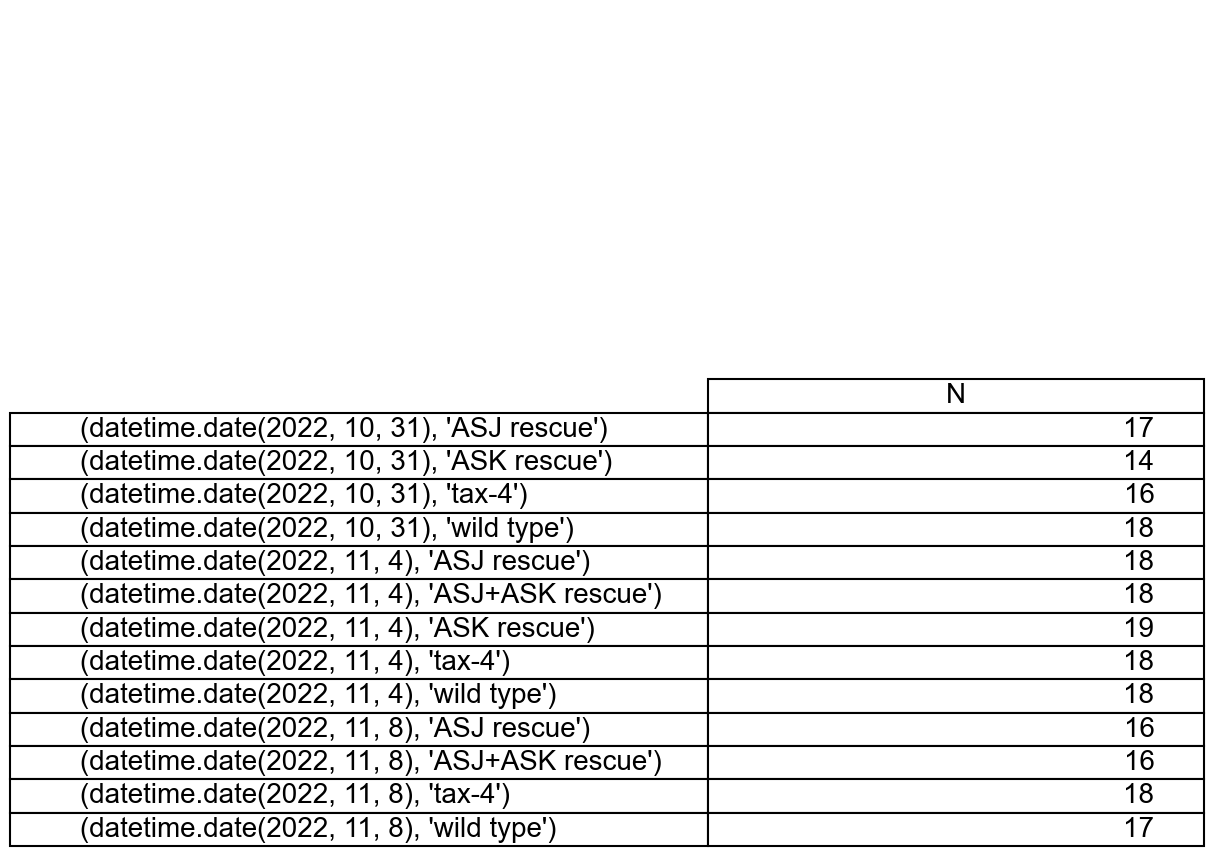

In [10]:
#plot a summary table showing N by date
import matplotlib.pyplot as plt
from pandas.plotting import table 

df_summary = Data_comparison_dfs['missingdata'].rename(columns={"matfilename":"N"}).groupby(["dates","genotype"]).count()['N']

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

ytable = table(ax, df_summary,fontsize=14)
ytable.set_fontsize(20)
ytable.scale(1, 2)

#prepare for saving:
# draw canvas once
plt.gcf().canvas.draw()
# get bounding box of table
points = ytable.get_window_extent(plt.gcf()._cachedRenderer).get_points()
# add 10 pixel spacing
points[0,:] -= 10; points[1,:] += 10
# get new bounding box in inches
nbbox = mpl.transforms.Bbox.from_extents(points/plt.gcf().dpi)

if saveFigures:
    if len(genNames)<100:
        outpath = os.path.join(subfolder,genNames+'_Data_N_summary'+'_'+datestring+'.png')
    else:
        outpath = os.path.join(subfolder,'Data_N_summary'+'_'+datestring+'.png')
    plt.savefig(outpath,bbox_inches=nbbox,dpi=300)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

light OFF vs. light ON: Custom statistical test, P_val:1.222e-10
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

light OFF vs. light ON: Custom statistical test, P_val:1.486e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

light OFF vs. light ON: Custom statistical test, P_val:2.855e-04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

light OFF vs. light ON: Custom statistical test, P_val:6.132e-01
p-value annotati

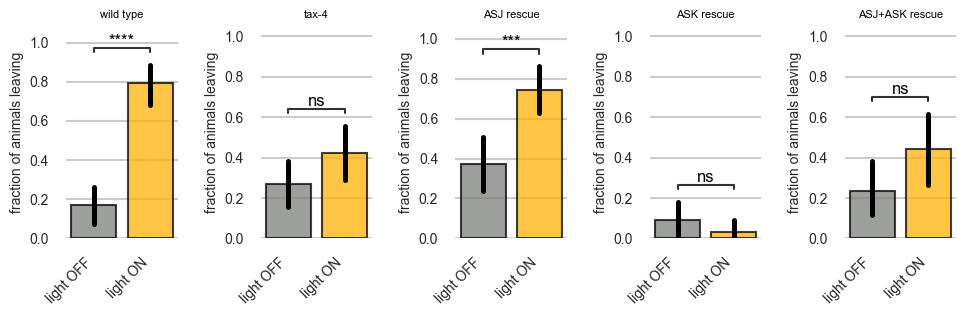

In [11]:
# FRACTION OF ANIMALS LEAVING, stats based on binary encoded 0 = no LL, 1 = at least one LL event per animal
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest, fisher_exact
from statsmodels.stats.proportion import proportion_confint
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest
from statannotations.Annotator import Annotator

binLight = binData(LIGHT_STIM,binSize,np.nanmean).astype(bool)[0]
lightOnIdx = np.where(binLight)[0]
lightOffIdx = np.where(~binLight)[0]

rot = 45

datakeys = list(Data_subs.keys())
fig,axs = plt.subplots(1,len(genotypes),figsize=(len(genotypes)*2,3.5))

pvals_dict = dict()
if len(genotypes)==1: #just in case there's only one genotype
    axs = [axs]
for i,key in enumerate(datakeys):
    Data = Data_subs[key]
    lawnExitsDuringLightOn = Data['bin_LawnExit_mostRecent'][:,lightOnIdx] #this counts animals only once across both stimulations
    lawnExitsDuringLightOff = Data['bin_LawnExit_mostRecent'][:,lightOffIdx]

    df_containsLL = pd.DataFrame(data={'light OFF':np.sum(lawnExitsDuringLightOff,axis=1)>0,'light ON':np.sum(lawnExitsDuringLightOn,axis=1)>0})
    df_containsLL = df_containsLL.unstack().reset_index(level=0).rename({"level_0":"light",0:"lawn exit"},axis='columns')
    # good seaborn method but can't manually add errorbars
    g = sns.barplot(data=df_containsLL,
                    x="light",
                    y="lawn exit",
                    ci=95,
                    palette = light_colors,
                    errcolor = "black",
                    edgecolor="black", 
                    saturation = 1, 
                    ax = axs[i])

#     #calculate pvalues using Dunn's posthoc test
#     pval_adj = sp.posthoc_dunn(df_containsLL, val_col = "lawn exit", group_col = "light", p_adjust = 'bonferroni')
#     for p in [["light OFF","light ON"]]:
#     pvalsToShowInOrder = []   
#     pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])

    #calculate pvalues using Fisher's Exact test
    data_0 = df_containsLL[df_containsLL['light']=="light OFF"]["lawn exit"]
    data_1 = df_containsLL[df_containsLL['light']=="light ON"]["lawn exit"]
    data_0_numSuccess = np.sum(data_0 == 1.0)
    data_0_numFail = np.sum(data_0 == 0.0)
    data_1_numSuccess = np.sum(data_1 == 1.0)
    data_1_numFail = np.sum(data_1 == 0.0)
    # top row = control, bottom row = experimental; left column = # success, right column = # fail
    contTable = np.array([[data_0_numSuccess, data_0_numFail], \
                          [data_1_numSuccess, data_1_numFail]])
    oddsr, p = fisher_exact(contTable, alternative='two-sided')
    # get 95% confidence intervals
    data_0_ci_lower, data_0_ci_upper = \
        proportion_confint(data_0_numSuccess, data_0_numSuccess + data_0_numFail, alpha=0.05)
    data_1_ci_lower, data_1_ci_upper = \
        proportion_confint(data_1_numSuccess, data_1_numSuccess + data_1_numFail, alpha=0.05)
    
    pvalsToShowInOrder = [p]
    pvals_dict[key] = p

    for bar in g.containers[0]:
        bar.set_alpha(0.75)
    g.set_xticklabels(g.get_xticklabels(), rotation=rot,fontstyle='normal',ha='right')
    g.set_ylabel("fraction of animals leaving")
    g.set_ylim(0,1.05)
    g.set_frame_on(False)
    g.set_xlabel('')
    annotator = Annotator(g, 
                          [["light OFF","light ON"]], 
                          data=df_containsLL, 
                          x="light",
                          y="lawn exit",
                          )
    annotator.configure(text_format='star', loc='inside',text_offset=0, fontsize=12)
    annotator.set_pvalues(pvalsToShowInOrder)
    _ = annotator.annotate()
    g.set_title(key,fontsize=8)

if saveFigures:
    outpath = os.path.join(subfolder,'Fraction_Leaving_ALL'+'_'+datestring+'.pdf')
    plt.savefig(outpath)

In [12]:
#save pvalues,
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pval_df["p value"]])
pval_df.to_csv(subfolder+"/"+"FractionLeaving_LightOFFvsON"+"_FishersExact"+"_pvalues.csv")


[2.01165244e-08]
[0.02526348]
[6.01681551e-07]
[0.15729921]


/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


[0.01144321]


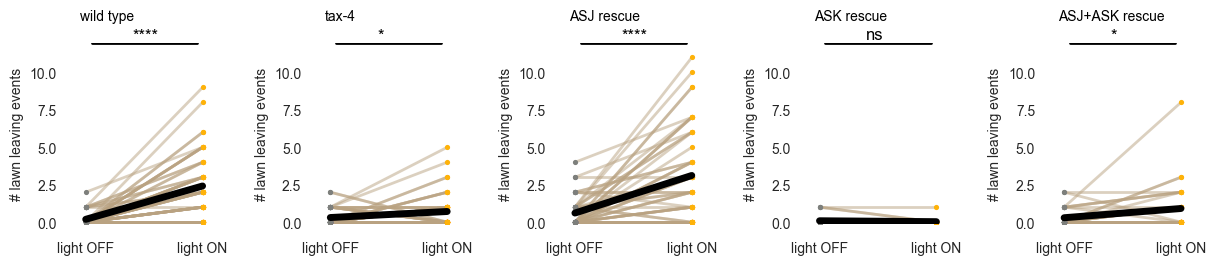

In [13]:
# Paired plots of # of lawn leaving events during light OFF versus light ON
from scipy.stats import wilcoxon

binLight = binData(LIGHT_STIM,binSize,np.nanmean).astype(bool)[0]
lightOnIdx = np.where(binLight)[0]
lightOffIdx = np.where(~binLight)[0]

maxval = 12

datakeys = list(Data_subs.keys())
pvals_dict = dict()

f,axs = plt.subplots(1,len(genotypes),figsize=(2.5*len(genotypes),3)) #for 2, use 2.5x
if len(genotypes)==1: #just in case there's only one genotype
    axs = [axs]
for i,key in enumerate(datakeys):
    Data = Data_subs[key]
    lawnExitsDuringLightOn = np.sum(Data['bin_LawnExit_mostRecent'][:,lightOnIdx],axis=1).reshape(-1,1) #this counts animals only once across both stimulations
    lawnExitsDuringLightOff = np.sum(Data['bin_LawnExit_mostRecent'][:,lightOffIdx],axis=1).reshape(-1,1)

    g = pairedScatterPlot(axs[i],lawnExitsDuringLightOff,lawnExitsDuringLightOn,light_colors[0],light_colors[2],light_colors[1],0.5)
    g.set_xticks([1,2])
    g.set_xticklabels(['light OFF','light ON'])
    g.set_xlabel('')
    g.set_xlim(0.9,2.1)
    g.set_ylim(-0.1,maxval)
#     g.grid(b='y')
    g.set_ylabel('# lawn leaving events')
    g.set_frame_on(False)
    
    stat,pval = wilcoxon(lawnExitsDuringLightOff,lawnExitsDuringLightOn)
    pvals_dict[key] = pval
    print(pval)
    
    g.text(1.4, maxval+0.2, categorizePValue(pval),fontsize=12)
    x1, y1 = [1.05, 1.95], [maxval,maxval]
    g.plot(x1, y1,linewidth=2,color='black')
    
    g.text(0.95, maxval+1.5,key,fontsize=10) #plot title


if saveFigures:
    outpath = os.path.join(subfolder,'NumLawnLeavingEvents_lightOFForON_pairedPlot'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

In [14]:
#save pvalues
#some kind of dataframe showing a bunch of parameters per genotype with light OFF and light ON comparisons
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pval_df["p value"]])
pval_df.to_csv(subfolder+"/"+"NumLLEvents_LightOFFvsON"+"_WilcoxonSignedRank"+"_pvalues.csv")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tax-4: Custom statistical test, P_val:2.702e-04
tax-4 vs. ASJ rescue: Custom statistical test, P_val:5.404e-03
ASJ rescue vs. ASK rescue: Custom statistical test, P_val:5.178e-05
ASK rescue vs. ASJ+ASK rescue: Custom statistical test, P_val:7.015e-01
wild type vs. ASJ rescue: Custom statistical test, P_val:1.000e+00
tax-4 vs. ASK rescue: Custom statistical test, P_val:1.000e+00
ASJ rescue vs. ASJ+ASK rescue: Custom statistical test, P_val:9.324e-02
wild type vs. ASK rescue: Custom statistical test, P_val:1.876e-06
tax-4 vs. ASJ+ASK rescue: Custom statistical test, P_val:1.000e+00
wild type vs. ASJ+ASK rescue: Custom statistical test, P_val:1.174e-02


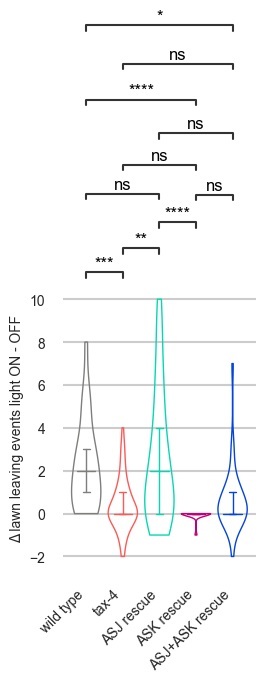

In [15]:
#Compare delta #lawn leaving events - unstranformed PostHoc Dunn
from scipy.stats import wilcoxon

binLight = binData(LIGHT_STIM,binSize,np.nanmean).astype(bool)[0]
lightOnIdx = np.where(binLight)[0]
lightOffIdx = np.where(~binLight)[0]

datakeys = list(Data_subs.keys())

deltaLE = []
#make a dataframe with columns as genotypes, and rows as the change in # of lawn leaving events
for i,key in enumerate(datakeys):
    Data = Data_subs[key]
    lawnExitsDuringLightOn = np.sum(Data['bin_LawnExit_mostRecent'][:,lightOnIdx],axis=1).reshape(-1,1) #this counts animals only once across both stimulations
    lawnExitsDuringLightOff = np.sum(Data['bin_LawnExit_mostRecent'][:,lightOffIdx],axis=1).reshape(-1,1)
    to_append = (lawnExitsDuringLightOn - lawnExitsDuringLightOff).reshape(1,-1)[0]
    deltaLE.append(to_append)
    

#plot accompanying boxplots
deltaLE_df = pd.DataFrame(data=stack_padding(deltaLE).T,columns=genotypes)
deltaLE_stacked = deltaLE_df.melt(var_name='groups', value_name='values')


pvalsToShowInOrder = []   
if len(genotypes)==2: 
    #define samples
    group1 = deltaLE_stacked[deltaLE_stacked['groups']==genotypes[0]].dropna()
    group2 = deltaLE_stacked[deltaLE_stacked['groups']==genotypes[1]].dropna()
    #perform independent two sample Mann-Whitney test
    _, pval_adj = mannwhitneyu(group1['values'], group2['values'])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = pval_adj = sp.posthoc_dunn(deltaLE_stacked,val_col='values', group_col='groups', p_adjust = 'bonferroni')
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")


if len(genotypes)==2:
    f,ax = plt.subplots(1,1,figsize=(2.2,4))
else:
    f,ax = plt.subplots(1,1,figsize=(0.6*len(genotypes),7))
# f,ax = plt.subplots(1,1,figsize=(1,3))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

g = customViolinBoxPlot(deltaLE_df, gen_colors, ax)
g.set_xticklabels(labels=genotypes,rotation=45,ha='right')
g.set_ylabel(u'Δ lawn leaving events light ON - OFF')


pairs = np.array(list(itertools.combinations(genotypes,2))) #use this instead in case one of the genotypes has no LE
if pairs.size>0:
    g.set_xlabel('')
    annotator = Annotator(g, 
                          pairs, 
                          data=deltaLE_stacked,
                            x='groups',
                          y='values')
    annotator.configure(text_format='star', loc='outside', fontsize=12)
    annotator.set_pvalues(pvalsToShowInOrder)
    _ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'NumLawnLeavingEvents_lightOFForON_Diff'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

In [16]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])
if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+"Delta_numLLevents"+"_MannWhitneyU"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+"Delta_numLLevents"+"_postHocDunn"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")

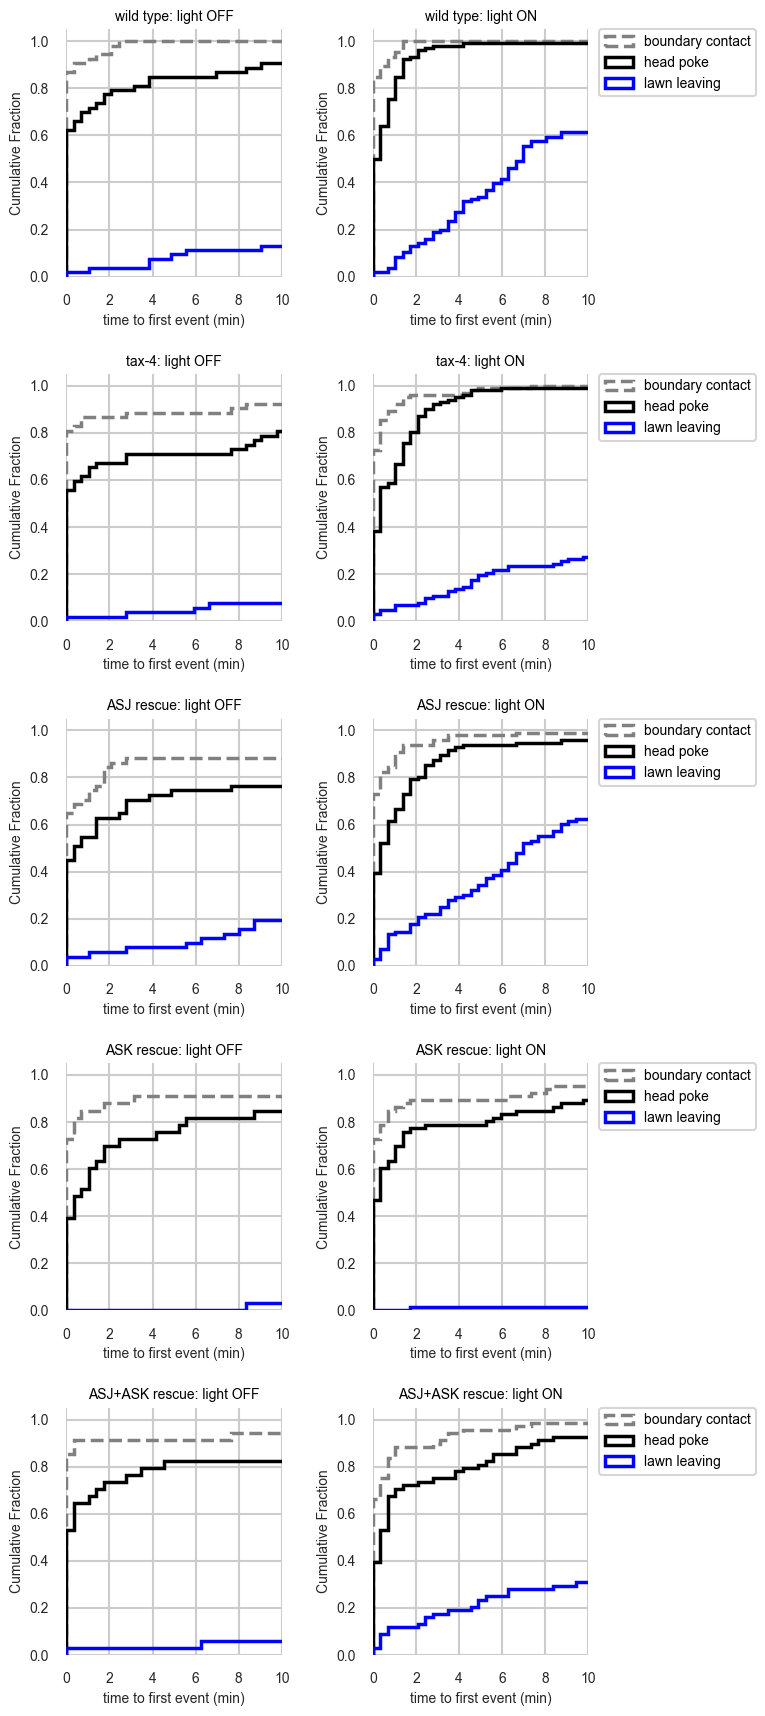

In [17]:
# time to first leaving event from LIGHT ON and LIGHT OFF

numMins = 10
framesPerMin = 6
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
binTimeAfter = (numMins*framesPerMin) # X minutes after
numLastBins= binTimeBefore

# fig,axs = plt.subplots(len(genotypes),2, sharey=False, tight_layout=True, figsize=(10,len(genotypes)*4))
fig,axs = plt.subplots(len(genotypes),2, sharey=False, tight_layout=True, figsize=(8,len(genotypes)*3.5))
LLBins = np.concatenate((np.linspace(0,numMins+0.1,30),[numMins+2]))
datakeys = list(Data_subs.keys())

if len(genotypes)==1: #just in case there's only one genotype
    axs = [axs]
for i,key in enumerate(datakeys):
    Data = Data_subs[key]
    mask = ~Data['InLawnRunMask']
    
    #define light stim pattern
    # bin_LIGHT_STIM_perRun = np.tile(bin_LIGHT_STIM,(len(Data['matfilename']),1))

    light_intervals = get_intervals(bin_LIGHT_STIM.astype(bool),0)
    light_ON = light_intervals[:,0]
#     light_ON = light_intervals[0,0] #just first light ON
    light_ON_vector = np.zeros_like(bin_LIGHT_STIM).astype(bool)
    light_ON_vector[light_ON]=True
    light_ON_stim_Mat = np.tile(light_ON_vector,(len(Data['matfilename']),1))

    light_OFF = light_intervals[:,1]
    if not useSecondOff:
        light_OFF = light_OFF[0]
    light_OFF_vector = np.zeros_like(bin_LIGHT_STIM).astype(bool)
    light_OFF_vector[light_OFF]=True
    light_OFF_stim_Mat = np.tile(light_OFF_vector,(len(Data['matfilename']),1))
    
    #this method counts every animal as two *independent* measurements, which is not accurate
    #we should align lawn leaving separately to the first and second light stimuli.
    #then ask:
    # 1) what fraction of animals left in the first stimulation period?
    # 2) across animals, how long until the first lawn exit in the first stimulation period? if the animal never left, the time should be set to infinity
    # 3) repeat this analysis for the second light pulse
    # 4) if the leaving curves look similar, could consider combining them as independent measures to increase N for distributions...
    
    bin_LawnExit_lightONaligned, binMask_lightONaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_LawnExit_mostRecent'],mask,light_ON_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)
    bin_LawnExit_lightOFFaligned, binMask_lightOFFaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_LawnExit_mostRecent'],mask,light_OFF_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)

    bin_HPall_lightONaligned, binMask_lightONaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_HeadPokesAll'],mask,light_ON_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)
    bin_HPall_lightOFFaligned, binMask_lightOFFaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_HeadPokesAll'],mask,light_OFF_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)

    edgeContact = abs(Data['bin_Lawn_Boundary_Dist_inLawn'])<0.5
    bin_edgeContact_lightONaligned, binMask_lightONaligned, binTimeLine, binAlignIdx = alignData_masked(edgeContact,mask,light_ON_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)
    bin_edgeContact_lightOFFaligned, binMask_lightOFFaligned, binTimeLine, binAlignIdx = alignData_masked(edgeContact,mask,light_OFF_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)

    #light on -- time to first lawn exit
    LLAfterLightON = bin_LawnExit_lightONaligned[:,binAlignIdx:]
    firstLLBin_AfterLightON = np.apply_along_axis(firstEventIdx,1,LLAfterLightON)/framesPerMin
    firstLLBin_AfterLightON[firstLLBin_AfterLightON<0] = numMins+1 #put the ones where nobody left outside of the stimulation range
#     firstLLBin_AfterLightON_LLonly = firstLLBin[firstLLBin>=0]

    #light off -- time to first lawn exit
    LLAfterLightOFF = bin_LawnExit_lightOFFaligned[:,binAlignIdx:]
    firstLLBin_AfterLightOFF = np.apply_along_axis(firstEventIdx,1,LLAfterLightOFF)/framesPerMin
    firstLLBin_AfterLightOFF[firstLLBin_AfterLightOFF<0] = numMins+1
#     firstLLBin_AfterLightOFF_LLonly = firstLLBin[firstLLBin>=0]

    #light on -- time to first HP
    HPAfterLightON = bin_HPall_lightONaligned[:,binAlignIdx:]
    firstHPBin_AfterLightON = np.apply_along_axis(firstEventIdx,1,HPAfterLightON)/framesPerMin
    firstHPBin_AfterLightON[firstHPBin_AfterLightON<0] = numMins+1
#     firstHPBin_AfterLightON_HPonly = firstHPBin[firstHPBin>=0]

    #light off -- time to first HP
    HPAfterLightOFF = bin_HPall_lightOFFaligned[:,binAlignIdx:]
    firstHPBin_AfterLightOFF = np.apply_along_axis(firstEventIdx,1,HPAfterLightOFF)/framesPerMin
    firstHPBin_AfterLightOFF[firstHPBin_AfterLightOFF<0] = numMins+1
#     firstHPBin_AfterLightOFF_HPonly = firstHPBin[firstHPBin>=0]
    
    #light on -- time to first edge contact
    EdgeContactAfterLightON = bin_edgeContact_lightONaligned[:,binAlignIdx:]
    firstEdgeContactBin_AfterLightON = np.apply_along_axis(firstEventIdx,1,EdgeContactAfterLightON)/framesPerMin
    firstEdgeContactBin_AfterLightON[firstEdgeContactBin_AfterLightON<0] = numMins+1
    #     firstEdgeContactBin_AfterLightON_EdgeContactonly = firstEdgeContactBin[firstEdgeContactBin>=0]

    #light off -- time to first edge contact
    EdgeContactAfterLightOFF = bin_edgeContact_lightOFFaligned[:,binAlignIdx:]
    firstEdgeContactBin_AfterLightOFF = np.apply_along_axis(firstEventIdx,1,EdgeContactAfterLightOFF)/framesPerMin
    firstEdgeContactBin_AfterLightOFF[firstEdgeContactBin_AfterLightOFF<0] = numMins+1
    #     firstEdgeContactBin_AfterLightOFF_EdgeContactonly = firstEdgeContactBin[firstEdgeContactBin>=0]

#     axs[i][0].hist(firstEdgeContactBin_AfterLightOFF_EdgeContactonly,bins=LLBins,density=False,linestyle='dashed',alpha=1,histtype='step',cumulative=True,lw=2.5,color='gray', label='boundary contact')
#     axs[i][0].hist(firstHPBin_AfterLightOFF_HPonly,bins=HPBins,density=False,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color='black', label='head poke')
#     axs[i][0].hist(firstLLBin_AfterLightOFF_LLonly,bins=LLBins,density=False,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color='blue', label='lawn leaving')

    axs[i][0].hist(firstEdgeContactBin_AfterLightOFF,bins=LLBins,density=True,linestyle='dashed',alpha=1,histtype='step',cumulative=True,lw=2.5,color='gray', label='boundary contact')
    axs[i][0].hist(firstHPBin_AfterLightOFF,bins=LLBins,density=True,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color='black', label='head poke')
    axs[i][0].hist(firstLLBin_AfterLightOFF,bins=LLBins,density=True,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color='blue', label='lawn leaving')
    fix_hist_step_vertical_line_at_end(axs[i][0])
#     axs[i][0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
    axs[i][0].set_xlim([0,numMins])
    axs[i][0].set_xlabel('time to first event (min)')
    axs[i][0].set_ylabel('Cumulative Fraction')
    axs[i][0].set_title(key+': light OFF')
    axs[i][0].set_frame_on(False)
    
#     axs[i][1].hist(firstEdgeContactBin_AfterLightON_EdgeContactonly,bins=LLBins,density=False,linestyle='dashed',alpha=1,histtype='step',cumulative=True,lw=2.5,color='gray', label='boundary contact')
#     axs[i][1].hist(firstHPBin_AfterLightON_HPonly,bins=HPBins,density=False,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color='black', label='head poke ')
#     axs[i][1].hist(firstLLBin_AfterLightON_LLonly,bins=LLBins,density=False,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color='blue', label='lawn leaving')
    
    axs[i][1].hist(firstEdgeContactBin_AfterLightON,bins=LLBins,density=True,linestyle='dashed',alpha=1,histtype='step',cumulative=True,lw=2.5,color='gray', label='boundary contact')
    axs[i][1].hist(firstHPBin_AfterLightON,bins=LLBins,density=True,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color='black', label='head poke ')
    axs[i][1].hist(firstLLBin_AfterLightON,bins=LLBins,density=True,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color='blue', label='lawn leaving')
    
#     axs[i][1].set_yticks()
    fix_hist_step_vertical_line_at_end(axs[i][1])
    axs[i][1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
    axs[i][1].set_xlim([0,numMins])
    axs[i][1].set_xlabel('time to first event (min)')
    axs[i][1].set_ylabel('Cumulative Fraction')
    axs[i][1].set_title(key+': light ON')
    axs[i][1].set_frame_on(False)
    
if saveFigures:
    outpath = os.path.join(subfolder,'TimeToFirstLawnExitandHeadPoke_lightON'+'_'+datestring)
    plt.savefig(outpath+'.pdf')
    #     plt.savefig(outpath+'.png',dpi=300)

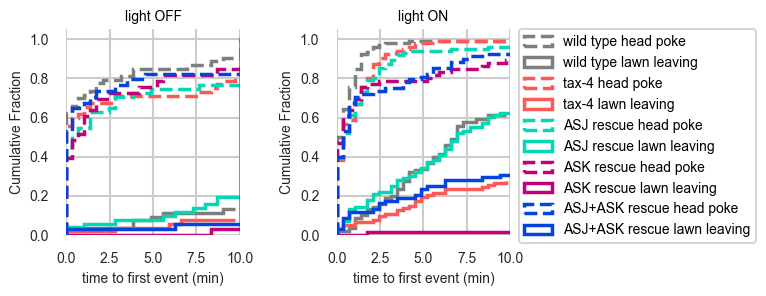

In [18]:
#overlay head poke and lawn leaving per genotype

numMins = 10
framesPerMin = 6
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
binTimeAfter = (numMins*framesPerMin) # X minutes after
numLastMins= binTimeBefore

#define light stim pattern
# bin_LIGHT_STIM_perRun = np.tile(bin_LIGHT_STIM,(len(Data['matfilename']),1))

light_intervals = get_intervals(bin_LIGHT_STIM.astype(bool),0)
light_ON = light_intervals[:,0]
#     light_ON = light_intervals[0,0] #just first light ON
light_ON_vector = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_ON_vector[light_ON]=True


light_OFF = light_intervals[:,1]
if not useSecondOff:
    light_OFF = light_OFF[0]
light_OFF_vector = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_OFF_vector[light_OFF]=True


fig,axs = plt.subplots(1,2, sharey=False, tight_layout=True, figsize=(8,3.3))
LLMins = np.concatenate((np.linspace(0,numMins+0.1,30),[numMins+2]))

first_LL_lightOFF_acrossgen = dict()
first_HP_lightOFF_acrossgen = dict()
first_LL_lightON_acrossgen = dict()
first_HP_lightON_acrossgen = dict()
                       
datakeys = list(Data_subs.keys())
for i,key in enumerate(datakeys):
    Data = Data_subs[key]
    mask = ~Data['InLawnRunMask']
    
    light_ON_stim_Mat = np.tile(light_ON_vector,(len(Data['matfilename']),1))
    light_OFF_stim_Mat = np.tile(light_OFF_vector,(len(Data['matfilename']),1))
                       
    bin_LawnExit_lightONaligned, binMask_lightONaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_LawnExit_mostRecent'],mask,light_ON_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)
    bin_LawnExit_lightOFFaligned, binMask_lightOFFaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_LawnExit_mostRecent'],mask,light_OFF_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)

    bin_HPall_lightONaligned, binMask_lightONaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_HeadPokesAll'],mask,light_ON_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)
    bin_HPall_lightOFFaligned, binMask_lightOFFaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_HeadPokesAll'],mask,light_OFF_stim_Mat,binTimeBefore,binTimeAfter,dtype=float)
    
    #NOTE:
    #keep in mind that this method inserts a value for each animal's first event timing
    #regardless of whether one actually ocurred during the stimulation interval
    #under the assumption that one would eventually occur by chance given enough time
    
    #light on -- time to first lawn exit
    LLAfterLightON = bin_LawnExit_lightONaligned[:,binAlignIdx:]
    firstLLMin_AfterLightON = np.apply_along_axis(firstEventIdx,1,LLAfterLightON)/framesPerMin
    firstLLMin_AfterLightON[firstLLMin_AfterLightON<0] = numMins+1 #put the ones where nobody left outside of the stimulation range
    first_LL_lightON_acrossgen[key] = firstLLMin_AfterLightON
    
    #light off -- time to first lawn exit
    LLAfterLightOFF = bin_LawnExit_lightOFFaligned[:,binAlignIdx:]
    firstLLMin_AfterLightOFF = np.apply_along_axis(firstEventIdx,1,LLAfterLightOFF)/framesPerMin
    firstLLMin_AfterLightOFF[firstLLMin_AfterLightOFF<0] = numMins+1
    first_LL_lightOFF_acrossgen[key] = firstLLMin_AfterLightOFF
    
    #light on -- time to first HP
    HPAfterLightON = bin_HPall_lightONaligned[:,binAlignIdx:]
    firstHPMin_AfterLightON = np.apply_along_axis(firstEventIdx,1,HPAfterLightON)/framesPerMin
    firstHPMin_AfterLightON[firstHPMin_AfterLightON<0] = numMins+1
    first_HP_lightON_acrossgen[key] = firstHPMin_AfterLightON

    #light off -- time to first HP
    HPAfterLightOFF = bin_HPall_lightOFFaligned[:,binAlignIdx:]
    firstHPMin_AfterLightOFF = np.apply_along_axis(firstEventIdx,1,HPAfterLightOFF)/framesPerMin
    firstHPMin_AfterLightOFF[firstHPMin_AfterLightOFF<0] = numMins+1
    first_HP_lightOFF_acrossgen[key] = firstHPMin_AfterLightOFF
                       
    axs[0].hist(firstHPMin_AfterLightOFF,bins=LLMins,density=True,linestyle='dashed',alpha=1,histtype='step',cumulative=True,lw=2.5,color=gen_colors[i], label=key+' head poke')
    axs[0].hist(firstLLMin_AfterLightOFF,bins=LLMins,density=True,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color=gen_colors[i], label=key+' lawn leaving')
    fix_hist_step_vertical_line_at_end(axs[0])
    axs[0].set_xlim([0,numMins])
    axs[0].set_xlabel('time to first event (min)')
    axs[0].set_ylabel('Cumulative Fraction')
    axs[0].set_title('light OFF')
    axs[0].set_frame_on(False)
                       
    axs[1].hist(firstHPMin_AfterLightON,bins=LLMins,density=True,linestyle='dashed',alpha=1,histtype='step',cumulative=True,lw=2.5,color=gen_colors[i], label=key+' head poke')
    axs[1].hist(firstLLMin_AfterLightON,bins=LLMins,density=True,linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2.5,color=gen_colors[i], label=key+' lawn leaving')
    fix_hist_step_vertical_line_at_end(axs[1])
    axs[1].set_xlim([0,numMins])
    axs[1].set_xlabel('time to first event (min)')
    axs[1].set_ylabel('Cumulative Fraction')
    axs[1].set_title('light ON')
    axs[1].set_frame_on(False)
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
    
if saveFigures:
    outpath = os.path.join(subfolder,'TimeToFirstLawnExitandHeadPoke_genotypeOverlay'+'_'+datestring)
    plt.savefig(outpath+'.pdf')



In [19]:
#Perform a Kolmogorov-Smirnov 2sample test across all genotype pairs, and then Bonferroni correct it
from scipy.stats import ks_2samp

#first LL light ON
firstLL_lightON_pvals = []
for i, p in enumerate(pairs):
    _,pval = ks_2samp(first_LL_lightON_acrossgen[p[0]], first_LL_lightON_acrossgen[p[1]], alternative='two-sided')
    firstLL_lightON_pvals.append(pval)
firstLL_lightON_pvals = np.array(firstLL_lightON_pvals)*len(pairs) #Bonferroni correct

#first LL light OFF
firstLL_lightOFF_pvals = []
for i, p in enumerate(pairs):
    _,pval = ks_2samp(first_LL_lightOFF_acrossgen[p[0]], first_LL_lightOFF_acrossgen[p[1]], alternative='two-sided')
    firstLL_lightOFF_pvals.append(pval)
firstLL_lightOFF_pvals = np.array(firstLL_lightOFF_pvals)*len(pairs) #Bonferroni correct

#first HP light ON
firstHP_lightON_pvals = []
for i, p in enumerate(pairs):
    _,pval = ks_2samp(first_HP_lightON_acrossgen[p[0]], first_HP_lightON_acrossgen[p[1]], alternative='two-sided')
    firstHP_lightON_pvals.append(pval)
firstHP_lightON_pvals = np.array(firstHP_lightON_pvals)*len(pairs) #Bonferroni correct

#first HP light OFF
firstHP_lightOFF_pvals = []
for i, p in enumerate(pairs):
    _,pval = ks_2samp(first_HP_lightOFF_acrossgen[p[0]], first_HP_lightOFF_acrossgen[p[1]], alternative='two-sided')
    firstHP_lightOFF_pvals.append(pval)
firstHP_lightOFF_pvals = np.array(firstHP_lightOFF_pvals)*len(pairs) #Bonferroni correct



#print pairs and significance stars to a text file
with open(subfolder+'/firstEventTiming_pVals.txt', 'w') as f:
    f.write('first LL event, light ON:')
    f.write('\n')
    for pair, p in zip(pairs,firstLL_lightON_pvals):
        f.write(str(pair)+','+str(p)+','+str(categorizePValue(p)))
        f.write('\n')
    f.write('first LL event, light OFF:')
    f.write('\n')
    for pair, p in zip(pairs,firstLL_lightOFF_pvals):
        f.write(str(pair)+','+str(p)+','+str(categorizePValue(p)))
        f.write('\n')
    f.write('first HP event, light ON:')
    f.write('\n')
    for pair, p in zip(pairs,firstHP_lightON_pvals):
        f.write(str(pair)+','+str(p)+','+str(categorizePValue(p)))
        f.write('\n')
    f.write('first HP event, light OFF:')
    f.write('\n')
    for pair, p in zip(pairs,firstHP_lightOFF_pvals):
        f.write(str(pair)+','+str(p)+','+str(categorizePValue(p)))
        f.write('\n')
    f.close()

3.803607214851888e-15
4.831308001570422e-12
2.4641474675883526e-12
0.48231053574922667
1.9844599447154568e-07


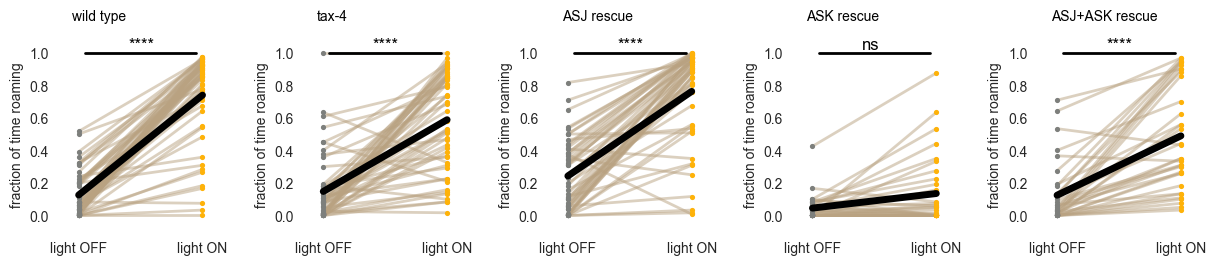

In [20]:
# fraction roaming during light OFF and light ON
from scipy.stats import ttest_rel
from scipy.special import logit

datakeys = list(Data_subs.keys())

f,axs = plt.subplots(1,len(genotypes),figsize=(2.5*len(genotypes),3)) #for 2, use 2.5x

pvals_dict = dict()
if len(genotypes)==1: #just in case there's only one genotype
    axs = [axs]
for i,key in enumerate(datakeys):
    Data = Data_subs[key]
    df = getFracRoamDwell_light(Data,lightOnIdx,lightOffIdx)
    df_roam = df.where(df.state=='roam').dropna()
    fracRoam_peranimal = df_roam.pivot(index='matfilename',columns='light',values='frac state')
    fracRoam_peranimal.columns = ['light OFF', 'light ON']

    lightOFF = fracRoam_peranimal['light OFF'].to_numpy().reshape(-1,1).astype(float)
    lightON = fracRoam_peranimal['light ON'].to_numpy().reshape(-1,1).astype(float)

    g = pairedScatterPlot(axs[i],lightOFF,lightON,light_colors[0],light_colors[2],light_colors[1],0.5)
    g.set_xticks([1,2])
    g.set_xticklabels(['light OFF','light ON'])
    g.set_xlabel('')
    g.set_xlim(0.9,2.1)
    g.set_ylim(-0.05,1.05)
    g.set_ylabel('fraction of time roaming')
    g.set_frame_on(False)
    
#     stat,pval = wilcoxon(fracRoam_peranimal['light OFF'],fracRoam_peranimal['light ON'])
    logitFracRoam_lightOFF = logit(linscaleData_minmax(fracRoam_peranimal['light OFF'],1/240,239/240))
    logitFracRoam_lightON = logit(linscaleData_minmax(fracRoam_peranimal['light ON'],1/240,239/240))
    _, pval_adj = ttest_rel(logitFracRoam_lightOFF, logitFracRoam_lightON)
    print(pval_adj)
    pvals_dict[key] = pval_adj
    
    g.text(1.4, 1.02, categorizePValue(pval_adj),fontsize=12)
    x1, y1 = [1.05, 1.95], [1,1]
    g.plot(x1, y1,linewidth=2,color='black')
    
    g.text(0.95, 1.2,key,fontsize=10) #plot title


if saveFigures:
    outpath = os.path.join(subfolder,'RDusage_lightOFForON_pairedPlot'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

In [21]:
#save pvalues, what raw data needs to be saved? 
#some kind of dataframe showing a bunch of parameters per genotype with light OFF and light ON comparisons
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pval_df["p value"]])
pval_df.to_csv(subfolder+"/"+"FracRoam_LightOFFvsON"+"_logit_paired_ttest"+"_pvalues.csv")

In [22]:
# fraction roaming during light OFF and light ON (fold change and delta) - unstranformed PostHoc Dunn
from scipy.stats import ttest_ind
from scipy.special import logit

datakeys = list(Data_subs.keys())

deltaRoam_foldchange = []
deltaRoam_diff = []

if len(genotypes)==1: #just in case there's only one genotype
    axs = [axs]
for i,key in enumerate(datakeys):
    Data = Data_subs[key]
    df = getFracRoamDwell_light(Data,lightOnIdx,lightOffIdx)
    df_roam = df.where(df.state=='roam').dropna()
    fracRoam_peranimal = df_roam.pivot(index='matfilename',columns='light',values='frac state')
    fracRoam_peranimal.columns = ['light OFF', 'light ON']

    lightOFF = fracRoam_peranimal['light OFF'].to_numpy().reshape(-1,1).astype(float)
    lightON = fracRoam_peranimal['light ON'].to_numpy().reshape(-1,1).astype(float)
    
    lightOFF_nonzeros = np.where(lightOFF!=0) #only use entries which have non-zero roaming during light OFF
    deltaRoam_foldchange.append(np.divide(lightON[lightOFF_nonzeros],lightOFF[lightOFF_nonzeros]).ravel())
    deltaRoam_diff.append((lightON - lightOFF).ravel())
    
    
df_deltaRoam_fc_df = pd.DataFrame(data=stack_padding(deltaRoam_foldchange).T,columns=genotypes)
df_deltaRoam_fc = df_deltaRoam_fc_df.melt(var_name='groups', value_name='values')
df_deltaRoam_diff_df = pd.DataFrame(data=stack_padding(deltaRoam_diff).T,columns=genotypes)
df_deltaRoam_diff = df_deltaRoam_diff_df.melt(var_name='groups', value_name='values')
df_deltaRoam_diff["logit_diff"] = logit(linscaleData_minmax(df_deltaRoam_diff["values"],1/240,239/240)) #very important addition, may change a lot! - data needs to be scaled to exclude 0 and 1 before Logit!

    
#DIFFERENCE    
if len(genotypes)==2:
    f,ax = plt.subplots(1,1,figsize=(2.2,4))
else:
    f,ax = plt.subplots(1,1,figsize=(0.6*len(genotypes),7))
    
pvalsToShowInOrder = []   
if len(genotypes)==2: 
    #define samples
    group1 = df_deltaRoam_diff[df_deltaRoam_diff['groups']==genotypes[0]]["logit_diff"].dropna()
    group2 = df_deltaRoam_diff[df_deltaRoam_diff['groups']==genotypes[1]]["logit_diff"].dropna()
    #perform independent two sample t-test on logit-transformed data
    _, pval_adj = ttest_ind(group1, group2)
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = pval_adj = sp.posthoc_tukey(df_deltaRoam_diff,val_col='logit_diff', group_col='groups')
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

g = customViolinBoxPlot(df_deltaRoam_diff_df, gen_colors, ax)

g.set_ylabel(u'Δ Frac. Roaming: light ON - OFF')
g.set_xticklabels(labels=genotypes,rotation=45,ha='right')

pairs = np.array(list(itertools.combinations(genotypes,2))) #use this instead in case one of the genotypes has no LE
if pairs.size>0:
    g.set_xlabel('')
    annotator = Annotator(g, 
                          pairs, 
                          data=df_deltaRoam_diff,
                            x='groups',
                          y='values')
    annotator.configure(text_format='star', loc='outside', fontsize=12)
    annotator.set_pvalues(pvalsToShowInOrder)
    _ = annotator.annotate()

    
if saveFigures:
    outpath = os.path.join(subfolder,'Roam_difference_lightON_OFF'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tax-4: Custom statistical test, P_val:6.384e-02
tax-4 vs. ASJ rescue: Custom statistical test, P_val:9.000e-01
ASJ rescue vs. ASK rescue: Custom statistical test, P_val:1.000e-03
ASK rescue vs. ASJ+ASK rescue: Custom statistical test, P_val:1.144e-02
wild type vs. ASJ rescue: Custom statistical test, P_val:3.096e-01
tax-4 vs. ASK rescue: Custom statistical test, P_val:1.000e-03
ASJ rescue vs. ASJ+ASK rescue: Custom statistical test, P_val:4.391e-01
wild type vs. ASK rescue: Custom statistical test, P_val:1.000e-03
tax-4 vs. ASJ+ASK rescue: Custom statistical test, P_val:8.037e-01
wild type vs. ASJ+ASK rescue: Custom statistical test, P_val:6.526e-03


In [23]:
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])
if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+"Delta_fracRoaming"+"_logit_ttest"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+"Delta_fracRoaming"+"_logit_postHocTukey"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")

In [24]:
aligned_figSize = (5*len(genotypes)+5,4)

In [25]:
#Midbody Forward Speed heatmaps and aligned overlays
import matplotlib.patches as patches

light_intervals = get_intervals(bin_LIGHT_STIM.astype(bool),0)
light_ON_first = light_intervals[:,0][0]
light_ON_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_ON_vector_first[light_ON_first]=True

light_OFF_first = light_intervals[:,1][0]
light_OFF_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_OFF_vector_first[light_OFF_first]=True

framesPerMin = 6
binTimeBefore = (10*framesPerMin) # X minutes before (3 fps)
binTimeAfter = (20*framesPerMin) # X minutes after
numLastBins= binTimeBefore
missingFracThresh = 0.7
upperlim = 0.1

bin_MidbodyForwardSpeed_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatasToLight(Data_subs, genotypes, 'bin_Midbody_fspeed', 'InLawnRunMask_centroid', light_ON_vector_first, binTimeBefore, binTimeAfter)

_, ax = plt.subplots(1, len(genotypes)+1, figsize=aligned_figSize)
# if len(genotypes)==1: #just in case there's only one genotype
#     ax = [ax]

xticksToPlot_hm = np.hstack((binTimeLine[0:-1:framesPerMin*5], binTimeLine[-1]))-binTimeLine[0]
xtickLabels_hm = np.ceil(xticksToPlot_hm / framesPerMin).astype(int)

for i, gen in enumerate(genotypes):
#     print(i)
    data = bin_MidbodyForwardSpeed_aligned[gen]
    
    ax[i] = plotAligned_Heatmap(ax[i], data, framesPerMin, binTimeLine, binTimeBefore, 0.0, 0.15, "",True,False,binAlignIdx,numLastBins)
    ax[i].vlines(10*6, 0, Data['InLawnRunMask'].shape[0], linestyles='dashed', color='white',zorder=2,lw=1)
    ax[i].vlines(20*6, 0, Data['InLawnRunMask'].shape[0], linestyles='dashed', color='white',zorder=2,lw=1)
    ax[i].set_xticks(xticksToPlot_hm)
    ax[i].set_xticklabels(xtickLabels_hm,rotation=0)
    ax[i].set_xlabel('time (min)')

    xd = 12*6+1
    yd = -0.5
    _ = ax[i].text(xd,yd, 'light ON',
                    fontsize = 10,zorder = 6,color = 'k',weight='bold', 
                    bbox={'facecolor':None, 'alpha':0, 'pad':2})
    
    comp_idx = len(genotypes)
    if len(genotypes)==1:
        ax[comp_idx] = plotMeanSEMCurve(ax[comp_idx],data,missingFracThresh,gen,binTimeLine,framesPerMin,'black')
    else:
        ax[comp_idx] = plotMeanSEMCurve(ax[comp_idx],data,missingFracThresh,gen,binTimeLine,framesPerMin,gen_colors[i])
    ax[comp_idx].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=10)
    ax[comp_idx].set_ylim(0.0,upperlim)
    xticksToPlot = np.arange(int(-1*(binTimeBefore/framesPerMin)),int(binTimeAfter/framesPerMin)+1,5)
    xtickLabels = (xticksToPlot+10).astype(int)
    ax[comp_idx].set_xticks(xticksToPlot)
    ax[comp_idx].set_xticklabels(xtickLabels,rotation=0)
   
_ = ax[comp_idx].text(2.7,upperlim+0.002, 'light ON',
            fontsize = 10,weight='bold',zorder = 6,color = 'k', 
            bbox={'facecolor':None, 'alpha':0, 'pad':2})
# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 10, 1, linewidth=1, edgecolor=None, facecolor=light_colors[1],alpha=0.15,zorder=7)
# Add the patch to the Axes
ax[comp_idx].add_patch(rect)

ax[comp_idx].set_ylabel("midbody forward speed (mm/sec)")
ax[comp_idx].set_xlabel('time (min)')
ax[comp_idx].set_frame_on(False)
    

#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array(([-10,0],[2,10],[12,20]))*6
p_vals, p_vals_starStrings = \
mwuCompareCurves_other_anytime(bin_MidbodyForwardSpeed_aligned, binAlignIdx, timeIntervals, pairs)
if len(genotypes)==2:
    level = upperlim-0.01
    for j,t in enumerate(timeIntervals):
        new_t = t/6
        ax[comp_idx].text(np.mean(new_t)-1, level+0.002, categorizePValue(p_vals[0][j]),fontsize=12)
        x1, y1 = new_t, [level ,level ]
        ax[comp_idx].plot(x1, y1,linewidth=2,color='black')
    
if saveFigures:
    outpath = os.path.join(subfolder,'MidbodyForwardSpeed_Light_aligned'+datestring)
    plt.savefig(outpath+'.pdf')
    plt.savefig(outpath+'.png',dpi=300)
    
if len(genotypes)>1:  
    #print pairs and significance stars to a text file
    with open(subfolder+'/MidbodyForwardSpeed_Aligned_Light_pVals.txt', 'w') as f:
        f.write('midbody forward speed: aligned during the following time intervals')
        f.write('\n')
        f.write(str(timeIntervals))
        f.write('\n')
        for pair, p, p_Strs in zip(pairs,p_vals,p_vals_starStrings):
            p_Strs = str(p_Strs)
            print(str(pair)+','+str(p)+': '+p_Strs)
            f.write(str(pair)+','+str(p)+': '+p_Strs)
            f.write('\n')
        f.close()


['wild type' 'tax-4'],[6.25777102e+00 1.03632304e-03 3.83579381e+00]: ['ns' '**' 'ns']
['wild type' 'ASJ rescue'],[3.67743983e+00 3.01754130e+00 3.82205177e-06]: ['ns' 'ns' '****']
['wild type' 'ASK rescue'],[2.78623067e+00 7.09517227e-11 2.93028271e-02]: ['ns' '****' '*']
['wild type' 'ASJ+ASK rescue'],[5.68821589e+00 1.36440147e-03 1.30763217e-02]: ['ns' '**' '*']
['tax-4' 'ASJ rescue'],[1.91033265e+00 2.90393746e-03 4.02605593e-04]: ['ns' '**' '***']
['tax-4' 'ASK rescue'],[5.03755005e+00 5.71112782e-08 6.04418918e-01]: ['ns' '****' 'ns']
['tax-4' 'ASJ+ASK rescue'],[2.3815087  3.53175656 0.36205434]: ['ns' 'ns' 'ns']
['ASJ rescue' 'ASK rescue'],[6.34085299e-01 2.14539856e-09 1.16912433e+00]: ['ns' '****' 'ns']
['ASJ rescue' 'ASJ+ASK rescue'],[9.09308128e+00 1.42012536e-03 2.24432158e-01]: ['ns' '**' 'ns']
['ASK rescue' 'ASJ+ASK rescue'],[9.91127615e-01 2.72826296e-04 6.11509901e+00]: ['ns' '***' 'ns']


['wild type' 'tax-4'],before: 0.009400639588798727,**; after: 0.0004406072419810069,***
['wild type' 'ASJ rescue'],before: 4.704707244989909e-05,****; after: 0.0004376126718155706,***
['wild type' 'ASK rescue'],before: 7.63358778625955,ns; after: 2.2900763358778624,ns
['wild type' 'ASJ+ASK rescue'],before: 0.00012986582873972756,***; after: 0.010410637057873848,*
['tax-4' 'ASJ rescue'],before: 6.960123594285436e-07,****; after: 3.6392422118198274e-08,****
['tax-4' 'ASK rescue'],before: 6.666666666666668,ns; after: 6.666666666666668,ns
['tax-4' 'ASJ+ASK rescue'],before: 2.7032413834593205,ns; after: 6.163338844803743,ns
['ASJ rescue' 'ASK rescue'],before: 4.78527607361963,ns; after: 1.9631901840490804,ns
['ASJ rescue' 'ASJ+ASK rescue'],before: 1.0152888578601264e-08,****; after: 4.278314890446281e-06,****
['ASK rescue' 'ASJ+ASK rescue'],before: 7.272727272727271,ns; after: 7.272727272727271,ns


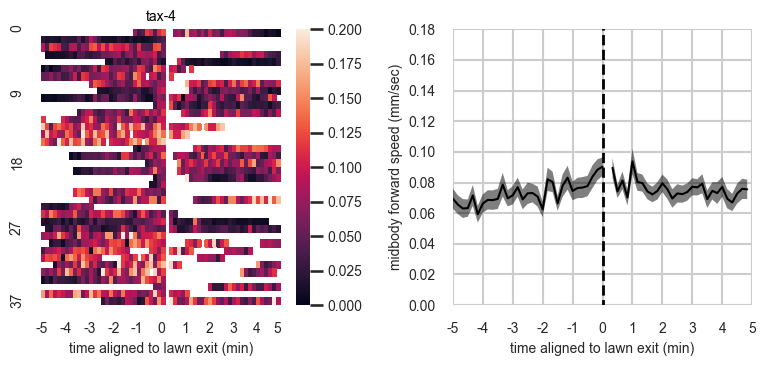

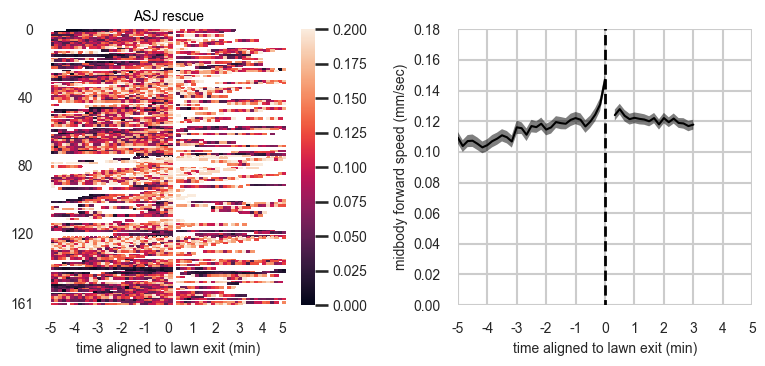

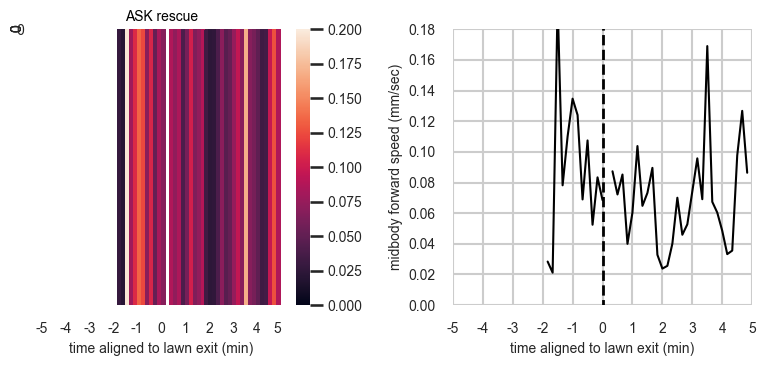

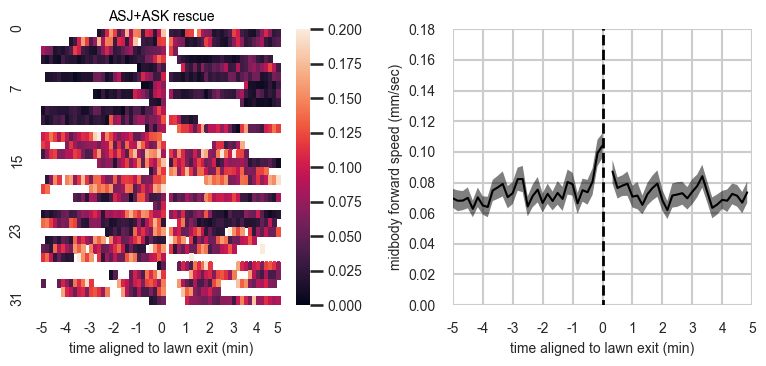

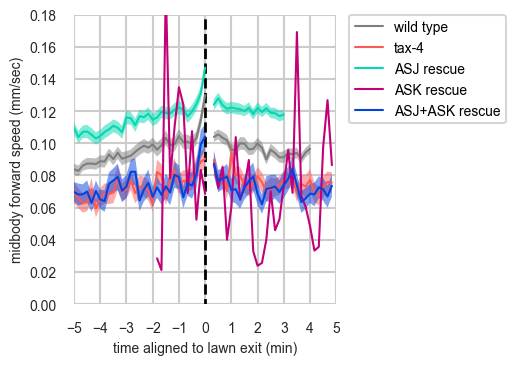

In [26]:
#MIDBODY FORWARD SPEED ALIGNED TO LAWN LEAVING (during Light ON)
import matplotlib.pyplot as plt
import numpy.matlib as mat

#align data to LL
framesPerMin = 6
numMins = 5
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = ((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.7
Data = list(Data_subs.items())[0][1]

#generate alignments to Lawn Exits only showing data from Light ON bits
lightON_mask = ~bin_LIGHT_STIM.astype(bool)
#make a masked array (mask out lights OFF, then generate alignments to LIGHT on lawn exits.)
lightON_mask_Mat = mat.repmat(lightON_mask,Data['bin_LawnExit_mostRecent'].shape[0],1)
LE = np.ma.array(Data['bin_LawnExit_mostRecent'], mask=lightON_mask_Mat)

bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],lightON_mask_Mat,LE,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

# minSpeed_c = 0.0
# maxSpeed_c = 0.15
# minSpeed_v = 0.0
# maxSpeed_v = 0.12

#for inedible food
minSpeed_c = 0.0
maxSpeed_c = 0.20
minSpeed_v = 0.0
maxSpeed_v = 0.18

for d_key, d_val in Data_subs.items():
    binLawnExit = d_val['bin_LawnExit_mostRecent']
    lightON_mask_Mat = mat.repmat(lightON_mask,binLawnExit.shape[0],1)
    overallMask = np.logical_or(lightON_mask_Mat,~d_val['InLawnRunMask'])#combine IN/OUT mask with LIGHT ON mask
    LE = np.ma.array(binLawnExit, mask=overallMask)
    
#     if np.sum(np.sum(LE))==0:
#         print("no LE: "+d_key)
#         continue
    bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(d_val['bin_Midbody_fspeed'],overallMask,LE,binTimeBefore,binTimeAfter,dtype=float)
#     bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(d_val['bin_Midbody_fspeed'],~d_val['InLawnRunMask'],d_val['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
    
    if bin_Midbody_fspeed_LLaligned.size==0:
        print("no LE: "+d_key)
        continue
        
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    ax = plotAligned_masked(ax, 
                            bin_Midbody_fspeed_LLaligned, 
                            binTimeLine, 
                            binTimeBefore, 
                            minSpeed_c, 
                            maxSpeed_c, 
                            framesPerMin, 
                            'midbody forward speed (mm/sec)', 
                            d_key,
                            sns.xkcd_palette(['black']),
                            True,
                            False,
                            binAlignIdx,
                            binTimeBefore,
                            True,missingFracThresh)
    
    
    ax[0].set_xlabel("time aligned to lawn exit (min)")
    ax[1].vlines(0, -200, 200, linestyle="--", color="black")
    ax[1].set_xlabel("time aligned to lawn exit (min)")
    ax[0].set_xticks(xticksToPlot + binTimeBefore)
    ax[0].set_xticklabels(xtickLabels,rotation=0)
    ax[1].set_xticks(xtickLabels)
    ax[1].set_xticklabels(xtickLabels)
    ax[1].set_xlim(-numMins,numMins)
    ax[1].set_ylim(minSpeed_v,maxSpeed_v)
    ax[1].set_frame_on(False)

    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'_MidbodyForwardSpeed_AlignedToLeaving_'+str(numMins)+'minBeforeAndAfter'+'_'+datestring+'.png')
        plt.savefig(outpath,dpi=300)
    
#Then just plot the averages overlayed
_, ax = plt.subplots(1, 1, figsize=(5.5,4))
bin_MidbodyFSpeed_aligned_allgens = dict()
for i, data in enumerate(Data_subs.values()):
    binLawnExit = data['bin_LawnExit_mostRecent']
    lightON_mask_Mat = mat.repmat(lightON_mask,binLawnExit.shape[0],1)
    overallMask = np.logical_or(lightON_mask_Mat,~data['InLawnRunMask'])#combine IN/OUT mask with LIGHT ON mask
    LE = np.ma.array(binLawnExit, mask=overallMask)
    
    bin_MidbodyFSpeed_aligned, Mask_aligned, binTimeLine, binAlignIdx = alignData_masked(
            data['bin_Midbody_fspeed'], overallMask, LE,
            binTimeBefore, binTimeAfter, dtype=float)
    
    bin_MidbodyFSpeed_aligned_allgens[genotypes[i]] = bin_MidbodyFSpeed_aligned

    if bin_MidbodyFSpeed_aligned.size==0:
        print("no LE: "+gen)
        continue
    ax = plotMeanSEMCurve(ax,bin_MidbodyFSpeed_aligned,missingFracThresh,genotypes[i],binTimeLine,framesPerMin,gen_colors[i])

ax.vlines(0, -200, 200, linestyle="--", color="black")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim(minSpeed_v,maxSpeed_v)
ax.set_xticks(xticksToPlot2)
ax.set_xlim(-numMins,numMins)

ax.set_ylabel("midbody forward speed (mm/sec)")
ax.set_xlabel("time aligned to lawn exit (min)")
ax.set_frame_on(False)
# ax.set_title('Midbody Forward Speed aligned to Lawn Exit')

if saveFigures:
    outpath = os.path.join(subfolder,'MidbodyFSpeed_LawnExit_aligned'+str(numMins)+'minBeforeAndAfter'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)
    outpath = os.path.join(subfolder,'MidbodyFSpeed_LawnExit_aligned'+str(numMins)+'minBeforeAndAfter'+'_'+datestring+'.png')
    plt.savefig(outpath,dpi=300)

#calculate pvalues for given pairs, bonferroni corrected
numMins = 2
p_Before, p_Before_starStrings, p_After, p_After_starStrings = \
mwuCompareCurves_other(bin_MidbodyFSpeed_aligned_allgens,binAlignIdx,pairs,numMins,framesPerMin)

#print pairs and significance stars to a text file
with open(subfolder+'/MidbodyFSpeedAlignedtoLeavingLightON_pVals.txt', 'w') as f:
    f.write('Midbody Forward Speed: '+str(numMins)+'mins aligned to lawn exits')
    f.write('\n')
    for pair, p_Bf, p_Af, p_BfStrs, p_AfStrs in zip(pairs,p_Before,p_After,p_Before_starStrings,p_After_starStrings):
        print(str(pair)+','+'before: '+str(p_Bf)+','+p_BfStrs+'; after: '+str(p_Af)+','+p_AfStrs)
        f.write(str(pair)+','+'before: '+str(p_Bf)+','+p_BfStrs+'; after: '+str(p_Af)+','+p_AfStrs)
        f.write('\n')
    f.close()


['wild type' 'tax-4'],[0.03900421]: ['*']
['wild type' 'ASJ rescue'],[0.00236198]: ['**']
['wild type' 'ASK rescue'],[1.47637795]: ['ns']
['wild type' 'ASJ+ASK rescue'],[0.57359758]: ['ns']
['tax-4' 'ASJ rescue'],[8.3145604e-06]: ['****']
['tax-4' 'ASK rescue'],[5.66801619]: ['ns']
['tax-4' 'ASJ+ASK rescue'],[8.04852776]: ['ns']
['ASJ rescue' 'ASK rescue'],[0.58059587]: ['ns']
['ASJ rescue' 'ASJ+ASK rescue'],[0.00084082]: ['***']
['ASK rescue' 'ASJ+ASK rescue'],[5.24369748]: ['ns']


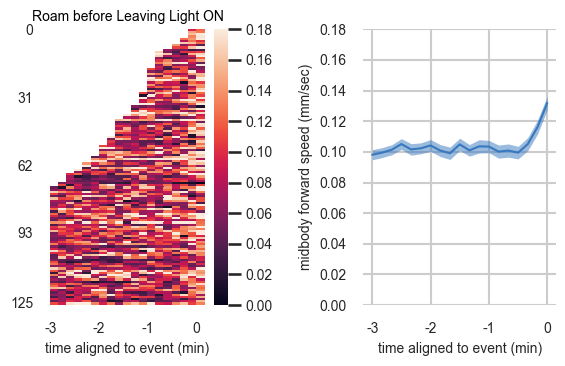

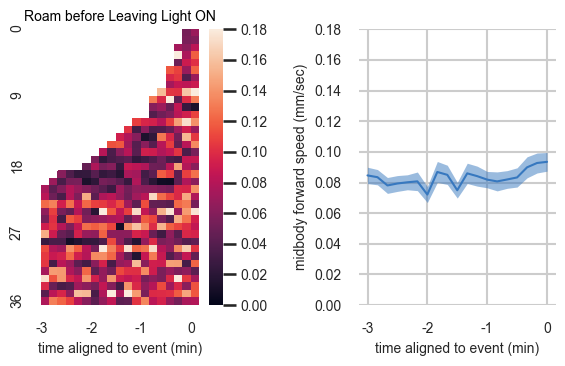

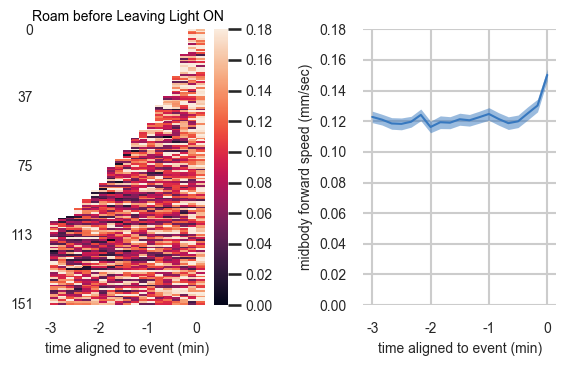

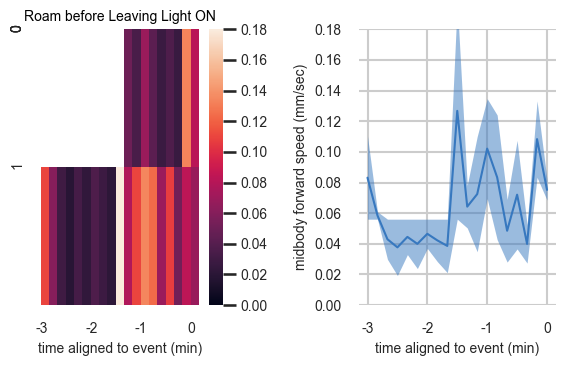

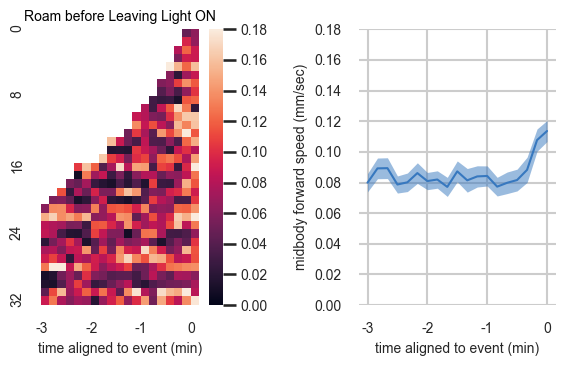

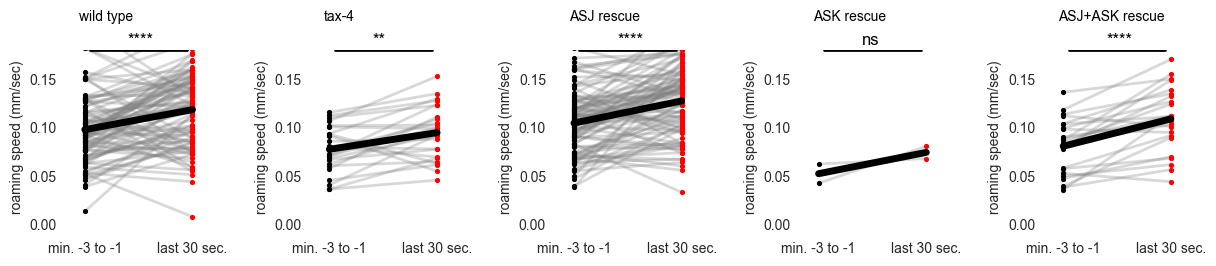

In [27]:
#Plot roaming speed aligned to lawn leaving
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy.matlib as mat
binsPerMin = 6

#align data to LL
numMins = 3
binTimeBefore = (numMins*framesPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#((numMins)*framesPerMin) # X minutes after
missingFracThresh = 0.7
Data = list(Data_subs.items())[0][1]
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],Data['bin_LawnExit_mostRecent']>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*framesPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / framesPerMin).astype(int)
timeLine2 = binTimeLine / framesPerMin
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

ymin = 0
ymax = 0.18

fig_overlay, ax_overlay = plt.subplots(1, 1, figsize=(4,4))
#paired plots
f_paired,axs_paired = plt.subplots(1,len(genotypes),figsize=(2.5*len(genotypes),3)) #for 2, use 2.5x
if len(genotypes)==1: #just in case there's only one genotype
    axs_paired = [axs_paired]

delta_RoamingSpeed = []
RoamingSpeed_LLaligned = dict()
pairedPlots_pvals_dict = dict()
i=0
for d_key, d_val in Data_subs.items():
    _, MLstatesRuns = getStateRunsBeforeEvent(d_val['RD_states_Matrix_exog_Cent'],True,d_val['bin_LawnExit_mostRecent'])
    binLawnExit_roam = np.logical_and(d_val['bin_LawnExit_mostRecent'],d_val['RD_states_Matrix_exog_Cent']) #subselect lawn exits that derive from roaming states
    
    #only during light ON
    #generate alignments to Lawn Exits only showing data from Light ON bits
    lightON_mask = ~bin_LIGHT_STIM.astype(bool)
    #make a masked array (mask out lights OFF, then generate alignments to LIGHT on lawn exits.)
    lightON_mask_Mat = mat.repmat(lightON_mask,d_val['bin_LawnExit_mostRecent'].shape[0],1)
    binLawnExit_roam_lightON = np.logical_and(binLawnExit_roam,~lightON_mask_Mat)
    
    LastRoam_inLawn = np.logical_and(~MLstatesRuns.mask,d_val['InLawnRunMask']) #True and True, invert it for the mask

    if np.sum(np.sum(binLawnExit_roam))<2:
        print("no LE: "+d_key)
        continue
        
    LL_aligned, mask_aligned, binTimeLine, binAlignIdx = \
    alignData_masked_lastRunOnly(d_val['bin_Midbody_fspeed'], ~LastRoam_inLawn, binLawnExit_roam, binTimeBefore, binTimeAfter, dtype=float)
    
    #last 30 seconds of LL_aligned
    last30seconds = np.nanmean(LL_aligned[:,-3:],axis=1).reshape(-1,1)
    prev2minutes = np.nanmean(LL_aligned[:,:12],axis=1).reshape(-1,1)#was 12
    goodIdx = np.where(np.logical_and(~np.isnan(last30seconds),~np.isnan(prev2minutes)))[0]
    last30seconds = last30seconds[goodIdx]
    prev2minutes = prev2minutes[goodIdx]
    speedDiff = last30seconds-prev2minutes
    delta_RoamingSpeed.append(speedDiff.ravel())
    
    stat,pval = wilcoxon(prev2minutes,last30seconds)
    pairedPlots_pvals_dict[d_key] = pval
    axs_paired[i].set_frame_on(False)
    g = pairedScatterPlot(axs_paired[i],prev2minutes,last30seconds,'black','gray','red',0.3)
    g.set_xticks([1,2])
    g.set_xticklabels(['min. -3 to -1','last 30 sec.'])
    g.set_xlabel('')
    g.set_ylabel('roaming speed (mm/sec)')
    g.set_xlim(0.9,2.1)
    g.set_ylim(0,ymax)
    g.text(1.4, ymax+0.005, categorizePValue(pval),fontsize=12)
    x1, y1 = [1.05, 1.95], [ymax,ymax]
    g.plot(x1, y1,linewidth=2,color='black')
    g.text(0.95, ymax+0.03,d_key,fontsize=10) #plot title

    fig,axs = plt.subplots(1,2,figsize=(6,4))
    axs = plotAligned_masked(axs, LL_aligned, binTimeLine, binTimeBefore,ymin, ymax, binsPerMin, 'midbody forward speed (mm/sec)', 'Roam before Leaving Light ON', colors, "length",
                                False, binAlignIdx, binTimeBefore,True,missingFracThresh)
    
    RoamingSpeed_LLaligned[d_key] = LL_aligned

    axs[1].set_frame_on(False)
    axs[1].set_ylim([ymin, ymax])
  
    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'_RoamingSpeedAlignedToLeaving_LightON_'+str(numMins)+'minBefore'+'_'+datestring)
        plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')
        plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
        
    
    plotMeanSEMCurve(ax_overlay,LL_aligned,missingFracThresh,d_key,binTimeLine,binsPerMin,gen_colors[i])
    i+=1

# save the paired plots
plt.figure(f_paired.number)
if saveFigures:
    outpath = os.path.join(subfolder,'RoamingSpeed_pairedPlots_LightON'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300)#,bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(outpath+'.pdf')#bbox_extra_artists=(lgd,), bbox_inches='tight')
    
#save pvalues
pval_df = pd.DataFrame.from_dict(pairedPlots_pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pval_df["p value"]])
pval_df.to_csv(subfolder+"/"+"RoamingSpeed_prev2min_last30sec_LightON"+"_WilcoxonSignedRank"+"_pvalues.csv")

# plot overlayed roaming speed
plt.figure(fig_overlay.number)
ax_overlay.set_frame_on(False)
ax_overlay.set_ylim(ymin,ymax)
ax_overlay.set_xticks(xticksToPlot2)
ax_overlay.set_xlim(-numMins,0)
ax_overlay.set_title('Roaming Speed light ON')
ax_overlay.set_ylabel("midbody forward speed (mm/sec)")
ax_overlay.set_xlabel("time aligned to lawn leaving (min)")
lgd = ax_overlay.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

if saveFigures:
    outpath = os.path.join(subfolder,'RoamingSpeed_AlignedtoLeaving_5minBefore_LightON'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array([[-3,0]]) #last 30 seconds
p_vals, p_vals_starStrings = mwuCompareCurves_other_anytime(RoamingSpeed_LLaligned,binAlignIdx,timeIntervals,pairs)


#print pairs and significance stars to a text file
with open(subfolder+'/FracStatesAligned_pVals.txt', 'a+') as f:
    f.write('Roaming speed: aligned to lawn leaving Light ON')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wild type vs. tax-4: Custom statistical test, P_val:1.000e+00
tax-4 vs. ASJ rescue: Custom statistical test, P_val:1.000e+00
ASJ rescue vs. ASK rescue: Custom statistical test, P_val:1.000e+00
ASK rescue vs. ASJ+ASK rescue: Custom statistical test, P_val:1.000e+00
wild type vs. ASJ rescue: Custom statistical test, P_val:1.000e+00
tax-4 vs. ASK rescue: Custom statistical test, P_val:1.000e+00
ASJ rescue vs. ASJ+ASK rescue: Custom statistical test, P_val:1.000e+00
wild type vs. ASK rescue: Custom statistical test, P_val:1.000e+00
tax-4 vs. ASJ+ASK rescue: Custom statistical test, P_val:1.000e+00
wild type vs. ASJ+ASK rescue: Custom statistical test, P_val:1.000e+00


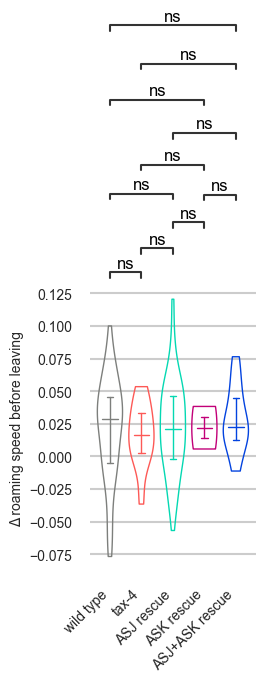

In [28]:
#plot and save delta roaming speed comparisons
delta_RoamingSpeed_df = pd.DataFrame(data=stack_padding(delta_RoamingSpeed).T,columns=genotypes)
delta_RoamingSpeed_stacked = delta_RoamingSpeed_df.melt(var_name='groups', value_name='values')

pvalsToShowInOrder = []   
if len(genotypes)==2: 
    #define samples
    group1 = delta_RoamingSpeed_stacked[delta_RoamingSpeed_stacked['groups']==genotypes[0]].dropna()
    group2 = delta_RoamingSpeed_stacked[delta_RoamingSpeed_stacked['groups']==genotypes[1]].dropna()
    #perform independent two sample Mann-Whitney test
    _, pval_adj = mannwhitneyu(group1['values'], group2['values'])
    pvalsToShowInOrder = [pval_adj]
elif len(genotypes)>2:
    pval_adj = pval_adj = sp.posthoc_dunn(delta_RoamingSpeed_stacked,val_col='values', group_col='groups', p_adjust = 'bonferroni')
    pvalsToShowInOrder = []
    for p in pairs:
        pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])
else:
    raise Exception("you need at least two genotypes to compare.")

    
if len(genotypes)==2:
    f,ax = plt.subplots(1,1,figsize=(2.2,4))
else:
    f,ax = plt.subplots(1,1,figsize=(0.6*len(genotypes),7))
# f,ax = plt.subplots(1,1,figsize=(1,3))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

g = customViolinBoxPlot(delta_RoamingSpeed_df, gen_colors, ax)
g.set_xticklabels(labels=genotypes,rotation=45,ha='right')
g.set_ylabel(u'Δ roaming speed before leaving')

pairs = np.array(list(itertools.combinations(genotypes,2))) #use this instead in case one of the genotypes has no LE
if pairs.size>0:
    g.set_xlabel('')
    annotator = Annotator(g, 
                          pairs, 
                          data=delta_RoamingSpeed_stacked,
                            x='groups',
                          y='values')
    annotator.configure(text_format='star', loc='outside', fontsize=12)
    annotator.set_pvalues(pvalsToShowInOrder)
    _ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'RoamingSpeed_prev2min_last30sec_LightON_Diff'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)
    
#save pvalues
pvals_dict = dict()
for i,p in enumerate(pairs):
    pvals_dict[p[0]+', '+p[1]] = pvalsToShowInOrder[i]
pval_df = pd.DataFrame.from_dict(pvals_dict, orient='index').rename(columns={0: "p value"})
pval_df.insert(loc=1, column="sigstars", value = [categorizePValue(p) for p in pvalsToShowInOrder])
if len(genotypes)==2:
    pval_df.to_csv(subfolder+"/"+"Delta_RoamingSpeed_LightON"+"_MannWhitneyU"+"_pvalues.csv")
elif len(genotypes)>2:
    pval_df.to_csv(subfolder+"/"+"Delta_RoamingSpeed_LightON"+"_postHocDunn"+"_pvalues.csv")
else:
    raise Exception("you need at least two genotypes to compare.")


In [29]:
#save data
dataToSave = []
for gen in genotypes:
    if gen in RoamingSpeed_LLaligned.keys():
        dataToSave.append(np.hstack((np.repeat(gen,RoamingSpeed_LLaligned[gen].shape[0]).reshape(-1,1), RoamingSpeed_LLaligned[gen].filled(np.nan))))
dataToSave = np.vstack(dataToSave)
data_aligned_df = pd.DataFrame(dataToSave).set_index(0)
data_aligned_df.to_csv(subfolder+"/"+"RoamingSpeed_LLaligned_LightON.csv")


In [30]:
#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array([[-3,0]])
p_vals, p_vals_starStrings = mwuCompareCurves_other_anytime(RoamingSpeed_LLaligned,binAlignIdx,timeIntervals,pairs)


#print pairs and significance stars to a text file
with open(subfolder+'/FracStatesAligned_pVals.txt', 'a+') as f:
    f.write('Roaming speed: aligned to lawn leaving light ON')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()


['wild type' 'tax-4'],[0.03900421]: ['*']
['wild type' 'ASJ rescue'],[0.00236198]: ['**']
['wild type' 'ASK rescue'],[1.47637795]: ['ns']
['wild type' 'ASJ+ASK rescue'],[0.57359758]: ['ns']
['tax-4' 'ASJ rescue'],[8.3145604e-06]: ['****']
['tax-4' 'ASK rescue'],[5.66801619]: ['ns']
['tax-4' 'ASJ+ASK rescue'],[8.04852776]: ['ns']
['ASJ rescue' 'ASK rescue'],[0.58059587]: ['ns']
['ASJ rescue' 'ASJ+ASK rescue'],[0.00084082]: ['***']
['ASK rescue' 'ASJ+ASK rescue'],[5.24369748]: ['ns']


['wild type' 'tax-4'],[2.89194912e+00 1.09317627e-07 2.29130721e-02]: ['ns' '****' '*']
['wild type' 'ASJ rescue'],[3.50171571e-02 9.09883938e-05 3.39616898e-10]: ['*' '****' '****']
['wild type' 'ASK rescue'],[4.47510611e-01 1.81560090e-09 3.95139907e-03]: ['ns' '****' '**']
['wild type' 'ASJ+ASK rescue'],[2.86589219e+00 2.65110033e-07 4.62862902e-06]: ['ns' '****' '****']
['tax-4' 'ASJ rescue'],[3.37252364e-04 7.24026093e-01 1.23746136e-04]: ['***' 'ns' '***']
['tax-4' 'ASK rescue'],[1.75257021 0.06707899 2.44760937]: ['ns' 'ns' 'ns']
['tax-4' 'ASJ+ASK rescue'],[0.28286617 9.60650118 0.10434765]: ['ns' 'ns' 'ns']
['ASJ rescue' 'ASK rescue'],[2.67530562e-05 2.50786555e-03 1.34948623e-01]: ['****' '**' 'ns']
['ASJ rescue' 'ASJ+ASK rescue'],[0.94481438 0.89214431 0.48502025]: ['ns' 'ns' 'ns']
['ASK rescue' 'ASJ+ASK rescue'],[0.01830161 0.04870085 4.18567722]: ['*' '*' 'ns']


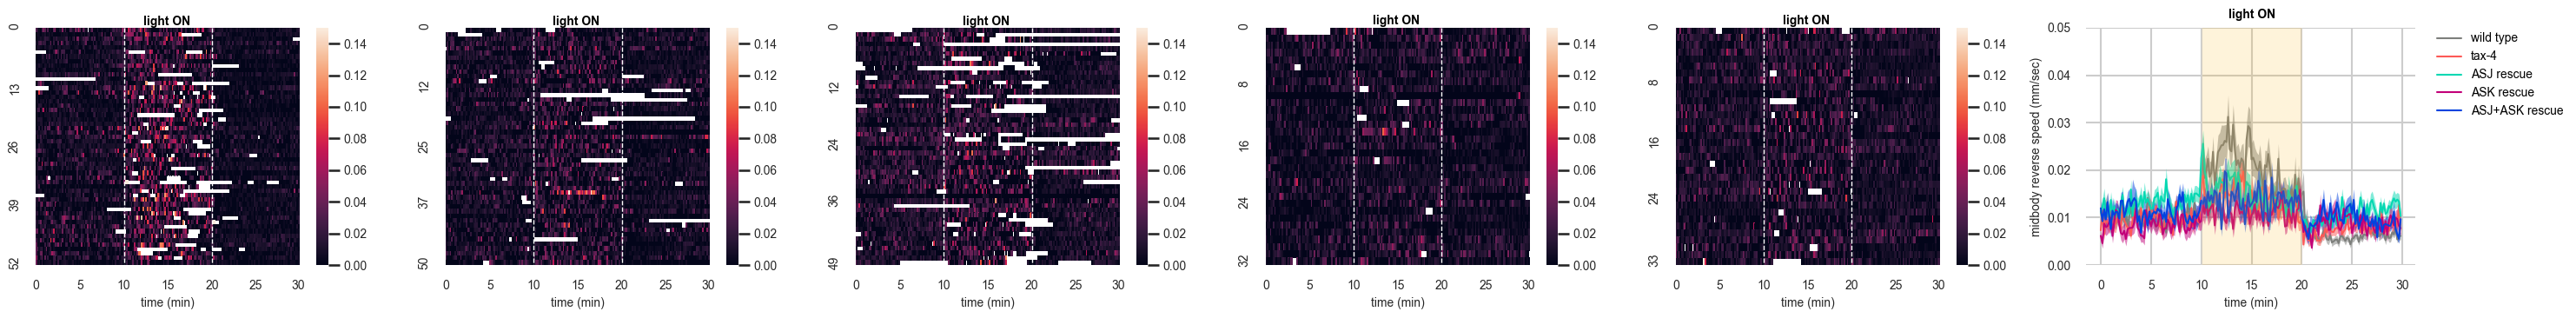

In [31]:
#Midbody Reverse Speed heatmaps and aligned overlays
import matplotlib.patches as patches

light_intervals = get_intervals(bin_LIGHT_STIM.astype(bool),0)
light_ON_first = light_intervals[:,0][0]
light_ON_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_ON_vector_first[light_ON_first]=True

light_OFF_first = light_intervals[:,1][0]
light_OFF_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_OFF_vector_first[light_OFF_first]=True

framesPerMin = 6
binTimeBefore = (10*framesPerMin) # X minutes before (3 fps)
binTimeAfter = (20*framesPerMin) # X minutes after
numLastBins= binTimeBefore
missingFracThresh = 0.7

bin_MidbodyReverseSpeed_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatasToLight(Data_subs, genotypes, 'bin_Midbody_rspeed', 'InLawnRunMask_centroid', light_ON_vector_first, binTimeBefore, binTimeAfter)

_, ax = plt.subplots(1, len(genotypes)+1, figsize=aligned_figSize)

xticksToPlot_hm = np.hstack((binTimeLine[0:-1:framesPerMin*5], binTimeLine[-1]))-binTimeLine[0]
xtickLabels_hm = np.ceil(xticksToPlot_hm / framesPerMin).astype(int)

for i, gen in enumerate(genotypes):
    data = bin_MidbodyReverseSpeed_aligned[gen]
    
    ax[i] = plotAligned_Heatmap(ax[i], data, framesPerMin, binTimeLine, binTimeBefore, 0.0, 0.15, "",True,False,binAlignIdx,numLastBins)
    ax[i].vlines(10*6, 0, Data['InLawnRunMask'].shape[0], linestyles='dashed', color='white',zorder=2,lw=1)
    ax[i].vlines(20*6, 0, Data['InLawnRunMask'].shape[0], linestyles='dashed', color='white',zorder=2,lw=1)
    ax[i].set_xticks(xticksToPlot_hm)
    ax[i].set_xticklabels(xtickLabels_hm,rotation=0)
    ax[i].set_xlabel('time (min)')

    xd = 12*6+1
    yd = -0.5
    _ = ax[i].text(xd,yd, 'light ON',
                    fontsize = 10,zorder = 6,color = 'k',weight='bold', 
                    bbox={'facecolor':None, 'alpha':0, 'pad':2})
    
    comp_idx = len(genotypes)
    if len(genotypes)==1:
        ax[comp_idx] = plotMeanSEMCurve(ax[comp_idx],data,missingFracThresh,gen,binTimeLine,framesPerMin,'black')
    else:
        ax[comp_idx] = plotMeanSEMCurve(ax[comp_idx],data,missingFracThresh,gen,binTimeLine,framesPerMin,gen_colors[i])
        
    ax[comp_idx].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=10)
    upperlim = 0.05
    ax[comp_idx].set_ylim(0.0,upperlim)
    xticksToPlot = np.arange(int(-1*(binTimeBefore/framesPerMin)),int(binTimeAfter/framesPerMin)+1,5)
    xtickLabels = (xticksToPlot+10).astype(int)
    ax[comp_idx].set_xticks(xticksToPlot)
    ax[comp_idx].set_xticklabels(xtickLabels,rotation=0)
   
_ = ax[comp_idx].text(2.7,upperlim+0.002, 'light ON',
            fontsize = 10,weight='bold',zorder = 6,color = 'k', 
            bbox={'facecolor':None, 'alpha':0, 'pad':2})
# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 10, 1, linewidth=1, edgecolor=None, facecolor=light_colors[1],alpha=0.15,zorder=7)
# Add the patch to the Axes
ax[comp_idx].add_patch(rect)

ax[comp_idx].set_ylabel("midbody reverse speed (mm/sec)")
ax[comp_idx].set_xlabel('time (min)')
ax[comp_idx].set_frame_on(False)


#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array(([-10,0],[2,10],[12,20]))*6
p_vals, p_vals_starStrings = \
mwuCompareCurves_other_anytime(bin_MidbodyReverseSpeed_aligned, binAlignIdx, timeIntervals, pairs)

if len(genotypes)==2:
    level = upperlim-0.01
    for j,t in enumerate(timeIntervals):
        new_t = t/6
        ax[comp_idx].text(np.mean(new_t)-1, level+0.002, categorizePValue(p_vals[0][j]),fontsize=12)
        x1, y1 = new_t, [level ,level ]
        ax[comp_idx].plot(x1, y1,linewidth=2,color='black')
    
if saveFigures:
    outpath = os.path.join(subfolder,'MidbodyReverseSpeed_Light_aligned'+datestring)
    plt.savefig(outpath+'.pdf')
    plt.savefig(outpath+'.png',dpi=300)

#print pairs and significance stars to a text file
with open(subfolder+'/MidbodyReverseSpeed_Aligned_Light_pVals.txt', 'w') as f:
    f.write('midbody reverse speed: aligned during the following time intervals')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()


['wild type' 'tax-4'],[2.5563294  0.0546779  3.54845035]: ['ns' 'ns' 'ns']
['wild type' 'ASJ rescue'],[4.87404728 2.81507321 1.11546291]: ['ns' 'ns' 'ns']
['wild type' 'ASK rescue'],[4.70334481e-01 4.39083502e-15 6.34248595e+00]: ['ns' '****' 'ns']
['wild type' 'ASJ+ASK rescue'],[8.32459971e+00 9.24691388e-04 3.25926774e+00]: ['ns' '***' 'ns']
['tax-4' 'ASJ rescue'],[6.77055449 1.13252789 4.35696432]: ['ns' 'ns' 'ns']
['tax-4' 'ASK rescue'],[3.61342677e+00 5.48989113e-08 7.58014092e+00]: ['ns' '****' 'ns']
['tax-4' 'ASJ+ASK rescue'],[2.75260528 1.3475849  8.04709272]: ['ns' 'ns' 'ns']
['ASJ rescue' 'ASK rescue'],[2.00243662e+00 7.53849976e-11 3.59069334e+00]: ['ns' '****' 'ns']
['ASJ rescue' 'ASJ+ASK rescue'],[4.57123754 0.05214158 6.85619258]: ['ns' 'ns' 'ns']
['ASK rescue' 'ASJ+ASK rescue'],[8.46640500e-01 7.34311211e-04 6.51459159e+00]: ['ns' '***' 'ns']


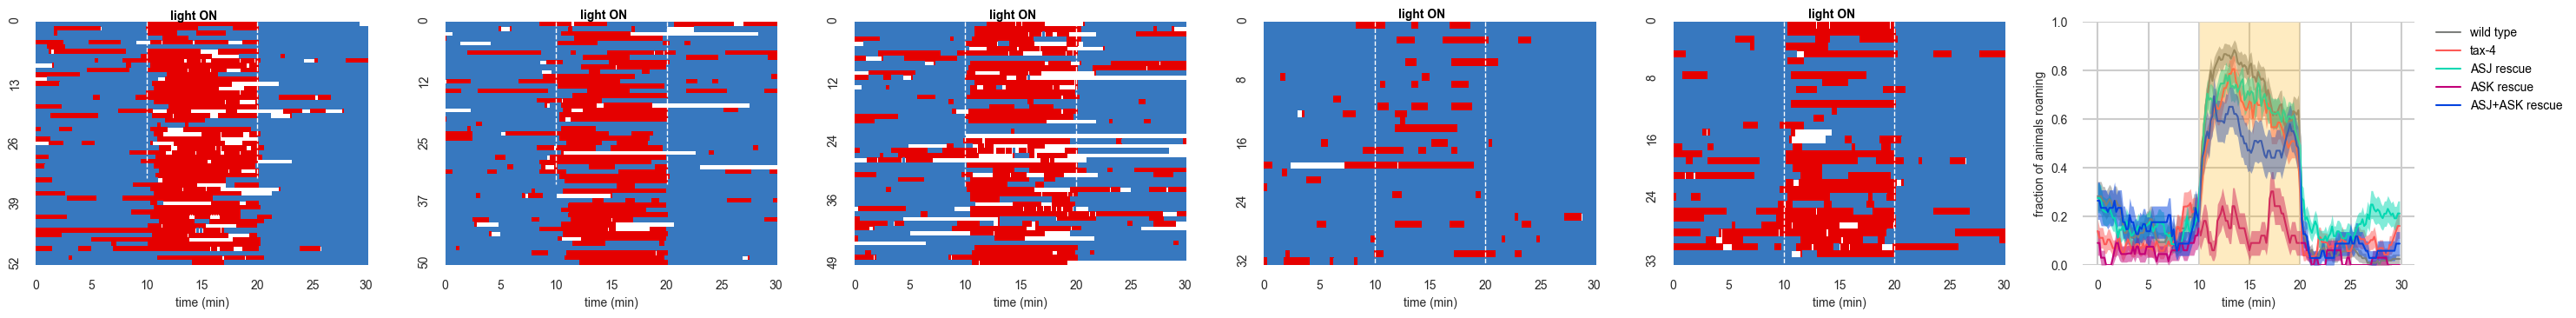

In [32]:
#align roaming across 10 min before, 10 min light ON, 10 min light OFF
import matplotlib.patches as patches

light_intervals = get_intervals(bin_LIGHT_STIM.astype(bool),0)
light_ON_first = light_intervals[:,0][0]
light_ON_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_ON_vector_first[light_ON_first]=True

light_OFF_first = light_intervals[:,1][0]
light_OFF_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_OFF_vector_first[light_OFF_first]=True

framesPerMin = 6
binTimeBefore = (10*framesPerMin) # X minutes before (3 fps)
binTimeAfter = (20*framesPerMin) # X minutes after
numLastBins= binTimeBefore
RD_hmm = Data_bracket[0]['RD_hmm_exog']

#Roaming aligned to LIGHT ON
bin_RoamDwell_aligned, mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatasToLight(Data_subs, genotypes, 'RD_states_Matrix_exog_Cent', 'InLawnRunMask_centroid', light_ON_vector_first, binTimeBefore, binTimeAfter)

#Lawn Exits aligned to LIGHT ON
bin_LawnExit_aligned, _, binTimeLine, binAlignIdx = \
alignSeveralDatasToLight(Data_subs, genotypes, 'bin_LawnExit_mostRecent', 'InLawnRunMask_centroid', light_ON_vector_first, binTimeBefore, binTimeAfter)

_, ax = plt.subplots(1, len(genotypes)+1, figsize=aligned_figSize)

xticksToPlot_hm = np.hstack((binTimeLine[0:-1:framesPerMin*5], binTimeLine[-1]))-binTimeLine[0]
xtickLabels_hm = np.ceil(xticksToPlot_hm / framesPerMin).astype(int)

comp_idx = len(genotypes) #which panel has the comparison

for i, gen in enumerate(genotypes):
    rd_data = bin_RoamDwell_aligned[gen]
#     curr_mask = mask_aligned[gen]
#     rd_data[curr_mask]=2.0 #make outside the lawn bouts yellow - THIS CODE MAKES THE FRACTION CALCULATION WRONG!
#     rd_data.mask = np.zeros_like(rd_data).astype(bool)
    le_data = bin_LawnExit_aligned[gen]
#     rd_hmm_copy = copy.deepcopy(RD_hmm)
#     rd_hmm_copy.K = 3
    ax[i] = plotMLstates_Aligned_heatmap(ax[i],rd_data,RD_hmm,binTimeLine,binTimeBefore,framesPerMin,'',colors)
    ax[i].vlines(10*6, 0, data.shape[0], linestyles='dashed', color='white',zorder=2,lw=1)
    ax[i].vlines(20*6, 0, data.shape[0], linestyles='dashed', color='white',zorder=2,lw=1)
    ax[i].set_xticks(xticksToPlot_hm)
    ax[i].set_xticklabels(xtickLabels_hm,rotation=0)
    ax[i].set_xlabel('time (min)')

    xd = 12*6+1
    yd = -0.5
    _ = ax[i].text(xd,yd, 'light ON',
                    fontsize = 10,zorder = 6,color = 'k',weight='bold', 
                    bbox={'facecolor':None, 'alpha':0, 'pad':2})
    
    if len(genotypes)==1:
        ax[comp_idx] = plotMeanSEMCurve(ax[comp_idx],rd_data,missingFracThresh,gen,binTimeLine,framesPerMin,'black')
    else:
        ax[comp_idx] = plotMeanSEMCurve(ax[comp_idx],rd_data,missingFracThresh,gen,binTimeLine,framesPerMin,gen_colors[i])
#     #plot the lawn exits as a raster above the comparison graph
#     exitIdx = np.where(le_data)[1]/6-10
#     for e in exitIdx:
#         ax[comp_idx].add_patch(Rectangle((e, 1.1+i/10), 0.05, 0.05,edgecolor=gen_colors[i], facecolor=gen_colors[i])) 

ax[comp_idx].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=10)
ax[comp_idx].set_ylim(0,1)
ax[comp_idx].set_yticks(np.arange(0,1.1,0.2))

ax[comp_idx].set_xticks(xticksToPlot)
ax[comp_idx].set_xticklabels(xtickLabels,rotation=0)

# _ = ax[comp_idx].text(2.7,1.025, 'light ON',
#                 fontsize = 10,weight='bold',zorder = 6,color = 'k', 
#                 bbox={'facecolor':None, 'alpha':0, 'pad':2})
# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 10, 1, linewidth=1, edgecolor=None, facecolor=light_colors[1],alpha=0.25,zorder=7)
# Add the patch to the Axes
ax[comp_idx].add_patch(rect)

ax[comp_idx].set_ylabel("fraction of animals roaming")
ax[comp_idx].set_xlabel('time (min)')
ax[comp_idx].set_frame_on(False)

#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array(([-10,0],[2,10],[12,20]))*6
pairs_out,p_vals, p_vals_starStrings = \
logit_ttest_CompareCurves_anytime(bin_RoamDwell_aligned,True,binAlignIdx,timeIntervals, pairs)

if len(genotypes)==2:
    level = 1.0
    for j,t in enumerate(timeIntervals):
        new_t = t/6
        ax[comp_idx].text(np.mean(new_t)-1, level+0.02, categorizePValue(p_vals[0][j]),fontsize=12)
        x1, y1 = new_t, [level ,level ]
        ax[comp_idx].plot(x1, y1,linewidth=2,color='black')

if saveFigures:
    outpath = os.path.join(subfolder,'RoamDwell_Cent_Light_aligned'+datestring)
    plt.savefig(outpath+'.pdf')
    plt.savefig(outpath+'.png',dpi=300)

#print pairs and significance stars to a text file
with open(subfolder+'/FracRoaming_Aligned_pVals.txt', 'w') as f:
    f.write('Fraction of Animals Roaming: aligned during the following time intervals')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()




In [33]:
#align arHMM states across 10 min before, 10 min light ON, 10 min light OFF
import matplotlib.patches as patches

light_intervals = get_intervals(bin_LIGHT_STIM.astype(bool),0)
light_ON_first = light_intervals[:,0][0]
light_ON_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_ON_vector_first[light_ON_first]=True

light_OFF_first = light_intervals[:,1][0]
light_OFF_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
light_OFF_vector_first[light_OFF_first]=True

framesPerMin = 6
binTimeBefore = (10*framesPerMin) # X minutes before (3 fps)
binTimeAfter = (20*framesPerMin) # X minutes after
numLastBins= binTimeBefore

#State3ing aligned to LIGHT ON
bin_ARHMMstates_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
alignSeveralDatasToLight(Data_subs, genotypes, 'arHMM_MLstates', 'InLawnRunMask_centroid', light_ON_vector_first, binTimeBefore, binTimeAfter)

_, ax = plt.subplots(1, len(genotypes)+1, figsize=aligned_figSize)

xticksToPlot_hm = np.hstack((binTimeLine[0:-1:framesPerMin*5], binTimeLine[-1]))-binTimeLine[0]
xtickLabels_hm = np.ceil(xticksToPlot_hm / framesPerMin).astype(int)

comp_idx = len(genotypes)

for i, gen in enumerate(genotypes):
    MLstates = bin_ARHMMstates_aligned[gen] #state 3
    data = MLstates==3.0
    data.mask = bin_ARHMMstates_aligned[gen].mask

    ax[i] = plotMLstates_Aligned_heatmap(ax[i],MLstates,arHMM_model,binTimeLine,binTimeBefore,framesPerMin,'',arhmm_colors)
    
    ax[i].vlines(10*6, 0, data.shape[0], linestyles='dashed', color='white',zorder=2,lw=1)
    ax[i].vlines(20*6, 0, data.shape[0], linestyles='dashed', color='white',zorder=2,lw=1)
    ax[i].set_xticks(xticksToPlot_hm)
    ax[i].set_xticklabels(xtickLabels_hm,rotation=0)
    ax[i].set_xlabel('time (min)')

    xd = 12*6+1
    yd = -0.5
    _ = ax[i].text(xd,yd, 'light ON',
                    fontsize = 10,zorder = 6,color = 'k',weight='bold', 
                    bbox={'facecolor':None, 'alpha':0, 'pad':2})
    
    if len(genotypes)==1:
        ax[comp_idx] = plotMeanSEMCurve(ax[comp_idx],data,missingFracThresh,gen,binTimeLine,framesPerMin,'black')
    else:
        ax[comp_idx] = plotMeanSEMCurve(ax[comp_idx],data,missingFracThresh,gen,binTimeLine,framesPerMin,gen_colors[i])

    
ax[comp_idx].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=10)
ax[comp_idx].set_ylim(0,1)

xticksToPlot = np.arange(int(-1*(binTimeBefore/framesPerMin)),int(binTimeAfter/framesPerMin)+1,5)
xtickLabels = (xticksToPlot+10).astype(int)

ax[comp_idx].set_xticks(xticksToPlot)
ax[comp_idx].set_xticklabels(xtickLabels,rotation=0)

# _ = ax[comp_idx].text(2.7,1.025, 'light ON',
#                 fontsize = 10,weight='bold',zorder = 6,color = 'k', 
#                 bbox={'facecolor':None, 'alpha':0, 'pad':2})
# Create a Rectangle patch
rect = patches.Rectangle((0, 0), 10, 1, linewidth=1, edgecolor=None, facecolor=light_colors[1],alpha=0.25,zorder=7)
# Add the patch to the Axes
ax[comp_idx].add_patch(rect)

ax[comp_idx].set_ylabel("fraction of animals in state 3")
ax[comp_idx].set_xlabel('time (min)')
ax[comp_idx].set_frame_on(False)


#calculate pvalues for given pairs, bonferroni corrected
timeIntervals = np.array(([-10,0],[2,10],[12,20]))*6
pairs_out,p_vals, p_vals_starStrings = \
logit_ttest_CompareCurves_anytime(bin_ARHMMstates_aligned,True,binAlignIdx,timeIntervals, pairs)

if len(genotypes)==2:
    level = 1.0
    for j,t in enumerate(timeIntervals):
        new_t = t/6
        ax[comp_idx].text(np.mean(new_t)-1, level+0.02, categorizePValue(p_vals[0][j]),fontsize=12)
        x1, y1 = new_t, [level ,level ]
        ax[comp_idx].plot(x1, y1,linewidth=2,color='black')

if saveFigures:
    outpath = os.path.join(subfolder,'arHMM_Light_aligned'+datestring)
    plt.savefig(outpath+'.pdf')
    plt.savefig(outpath+'.png',dpi=300)

#print pairs and significance stars to a text file
with open(subfolder+'/FracState3_Aligned_pVals.txt', 'w') as f:
    f.write('Fraction of Animals in State 3: aligned during the following time intervals')
    f.write('\n')
    f.write(str(timeIntervals))
    f.write('\n')
    for pair, p, p_Strs in zip(pairs,p_vals,p_vals_starStrings):
        p_Strs = str(p_Strs)
        print(str(pair)+','+str(p)+': '+p_Strs)
        f.write(str(pair)+','+str(p)+': '+p_Strs)
        f.write('\n')
    f.close()




['wild type' 'tax-4'],[6.06906335 1.59450035 9.75033237]: ['ns' 'ns' 'ns']
['wild type' 'ASJ rescue'],[2.7276776  6.84938597 4.22194133]: ['ns' 'ns' 'ns']
['wild type' 'ASK rescue'],[4.70433005e+00 3.62703580e-05 7.71741730e+00]: ['ns' '****' 'ns']
['wild type' 'ASJ+ASK rescue'],[5.83991932 1.88356091 2.71566469]: ['ns' 'ns' 'ns']
['tax-4' 'ASJ rescue'],[1.08148298 0.65500262 4.37720526]: ['ns' 'ns' 'ns']
['tax-4' 'ASK rescue'],[7.58219864e+00 2.18574372e-03 7.90379631e+00]: ['ns' '**' 'ns']
['tax-4' 'ASJ+ASK rescue'],[3.12010305 9.21192632 2.5561268 ]: ['ns' 'ns' 'ns']
['ASJ rescue' 'ASK rescue'],[1.08307834e+00 5.88480325e-06 6.46614172e+00]: ['ns' '****' 'ns']
['ASJ rescue' 'ASJ+ASK rescue'],[6.75803021 0.88052735 1.16593856]: ['ns' 'ns' 'ns']
['ASK rescue' 'ASJ+ASK rescue'],[2.71955486 0.01565909 2.09604086]: ['ns' '*' 'ns']


/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-34-dd90d046241c>:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
<ipython-input-34-dd90d046241c>:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipyth

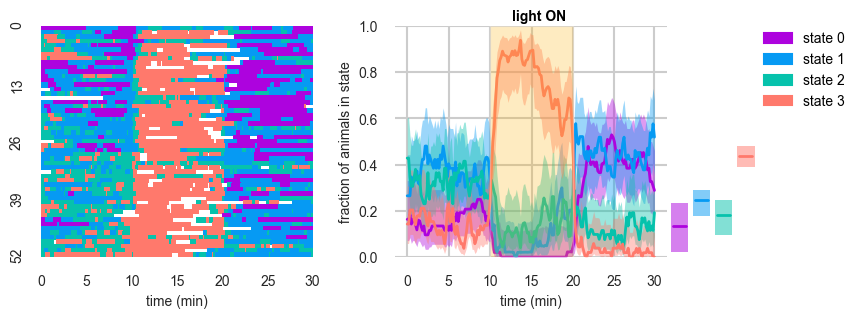

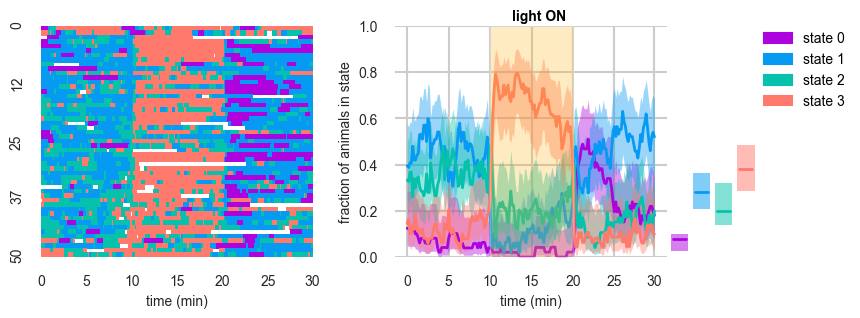

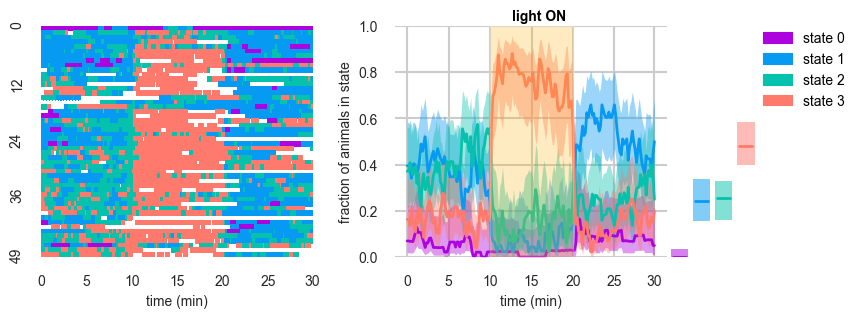

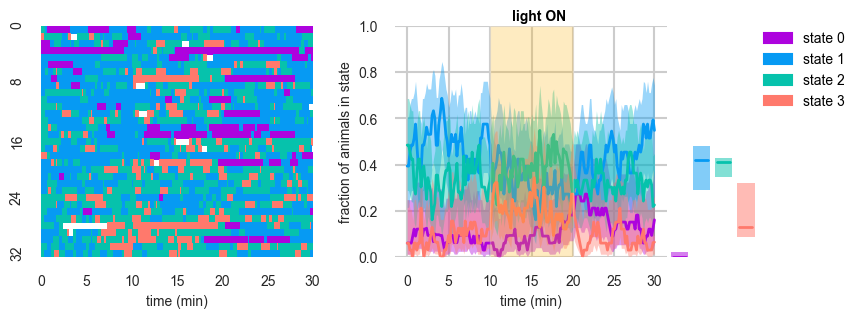

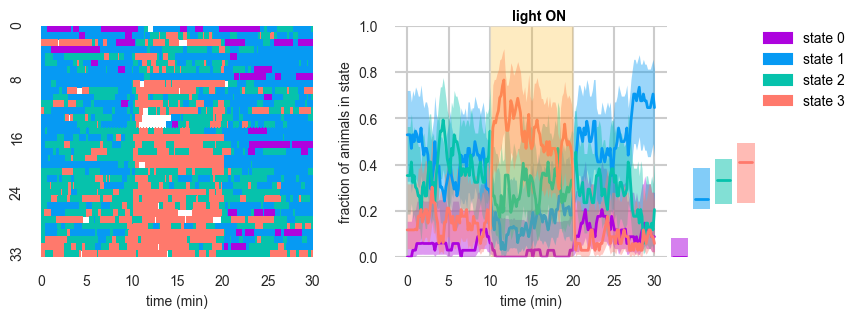

In [34]:
#align arHMM states across 10 min before, 10 min light ON, 10 min light OFF - show all 4 states for a single genotype
import matplotlib.patches as patches
import numpy.matlib as mat

binsPerMin = 6
binTimeBefore = (10*framesPerMin) # X minutes before (3 fps)
binTimeAfter = (20*framesPerMin) # X minutes after
numLastBins= binTimeBefore

xticksToPlot = np.hstack((binTimeLine[0:-1:5*binsPerMin], binTimeLine[-1]))
xtickLabels = np.ceil(xticksToPlot / binsPerMin).astype(int)+10

#arHMM states aligned to LIGHT ON


for d_key, d_val in Data_subs.items():
    f, ax = plt.subplots(1, 3, figsize=(10,3), gridspec_kw={'width_ratios': [2,2,0.5],'hspace':0,'wspace':0.4})

    light_intervals = get_intervals(bin_LIGHT_STIM.astype(bool),0)
    light_ON_first = light_intervals[:,0][0]
    light_ON_vector_first = np.zeros_like(bin_LIGHT_STIM).astype(bool)
    light_ON_vector_first[light_ON_first]=True


    light_ON_stim_Mat_first = mat.repmat(light_ON_vector_first,d_val['bin_LawnExit_mostRecent'].shape[0],1)

    ax,dfToPlot = plotMLstates_Aligned_masked(ax,
                                     d_val['arHMM_MLstates'],
                                     arHMM_model,
                                     ~d_val['InLawnRunMask'],
                                     light_ON_stim_Mat_first,
                                     binTimeLine,
                                     binTimeBefore,
                                     binTimeAfter,
                                     binsPerMin,
                                     '',
                                     arhmm_colors,
                                     numLastBins,
                                     False,
                                     figsize=aligned_figSize)

    ax[0].set_xticks(xticksToPlot + binTimeBefore)
    ax[0].set_xticklabels(xtickLabels,rotation=0)
    ax[0].set_xlabel('time (min)')

    binTimeLine2 = binTimeLine / binsPerMin
    xticksToPlot2 = np.hstack((binTimeLine2[0:-1:5*binsPerMin], binTimeLine2[-1]))
    ax[1].set_xticks(xticksToPlot2)
    ax[1].set_xticklabels(xtickLabels,rotation=0)
    ax[1].set_frame_on(False)
    ax[1].set_ylim(0,1)
    ax[1].set_xlabel('time (min)')
    ax[1].set_ylabel('fraction of animals in state')


    #get all R/D values so we can generate barplots with confidence intervals
    MLstates_overall = d_val['arHMM_MLstates']
    fracstate0_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==0.0,axis=1)
    fracstate1_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==1.0,axis=1)
    fracstate2_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==2.0,axis=1)
    fracstate3_leavers = np.nanmean(MLstates_overall[np.where(np.sum(d_val['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==3.0,axis=1)

    fracARHMMstates = [fracstate0_leavers,fracstate1_leavers,fracstate2_leavers,fracstate3_leavers]
    fracARHMMstates_stacked = pd.DataFrame(data=stack_padding(fracARHMMstates).T,columns=['state 0','state 1','state 2','state 3'])

    ###########
    #plot accompanying boxplots #change this to have the same look as the plots with SEM
    g = sns.boxplot(data=fracARHMMstates_stacked,
                showfliers=False,
                whis=0,
                palette = colors,
                saturation = 1,
                ax = ax[2])

    # DIY custom boxplot
    for i,box in enumerate(g.artists):
        box.set_edgecolor(mpl.colors.to_rgba(arhmm_colors[i], 0))
        box.set_facecolor(mpl.colors.to_rgba(arhmm_colors[i], 0.50))
        # iterate over whiskers and median lines
        for j in g.lines:
             j.set_color(mpl.colors.to_rgba(colors[i], 0))

    #make the medians pop
    m_width = 0.6
    medians = fracARHMMstates_stacked.melt().groupby("variable").median().reindex(['state 0','state 1','state 2','state 3'])
    for i,xtick in enumerate(g.get_xticks()):
        g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= arhmm_colors[i], linestyle='-', linewidth=2,zorder=3)

    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    ax[2].set_ylim(0,1)
    ax[2].set_yticks([]) 
    ##################

    #move axes around
    box = ax[2].get_position()
    ax[2].set_position([box.x0-0.08, box.y0, box.width*1.3, box.height])
    ax[2].set_frame_on(False)
    ax[2].set_xticks([])
    # create color map with colors and df.names
    cmap = dict(zip(fracARHMMstates_stacked.columns, arhmm_colors))
    # create the rectangles for the legend
    patches_h = [patches.Patch(color=v, label=k) for k, v in cmap.items()]
    # add the legend
    lgd = ax[2].legend(handles=patches_h, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

    _ = ax[1].text(2.7,1.025, 'light ON',
                    fontsize = 10,weight='bold',zorder = 6,color = 'k', 
                    bbox={'facecolor':None, 'alpha':0, 'pad':2})
    # Create a Rectangle patch
    rect = patches.Rectangle((0, 0), 10, 1, linewidth=1, edgecolor=None, facecolor=light_colors[1],alpha=0.25,zorder=7)
    # Add the patch to the Axes
    ax[1].add_patch(rect)


    if saveFigures:
        outpath = os.path.join(subfolder,d_key+'_arHMM_states_ALL_Light_aligned'+datestring)
        plt.savefig(outpath+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')



In [35]:
color_names = ['vibrant purple','azure','turquoise','salmon']
arhmm_colors = sns.xkcd_palette(color_names)

<ipython-input-36-accc9e5af514>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2,1,figsize=(12,3),sharex=True,frameon=False)


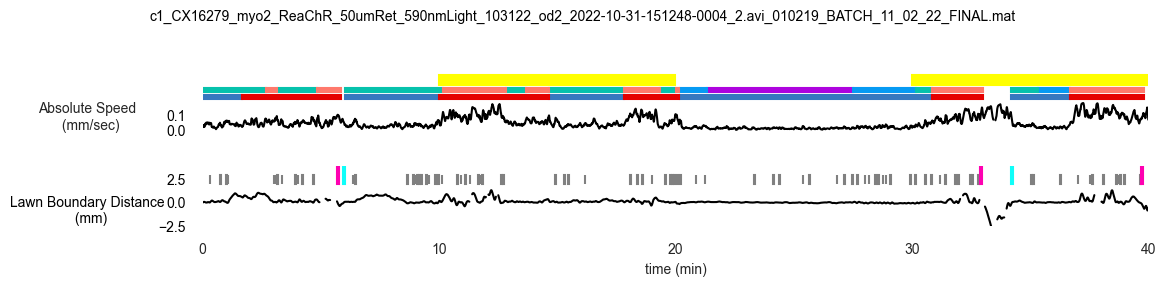

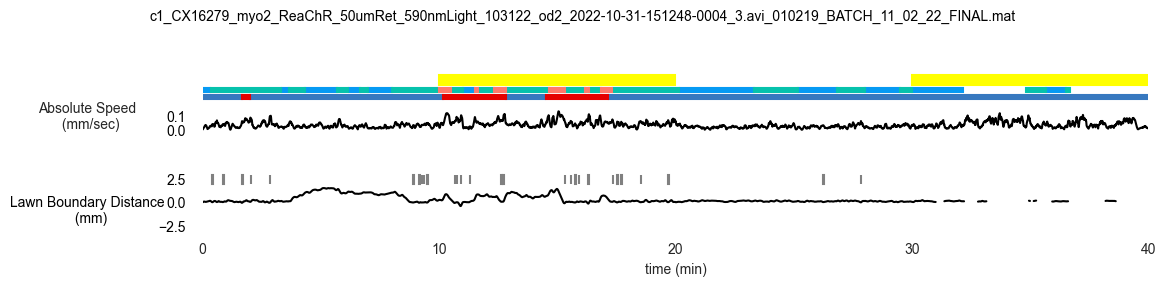

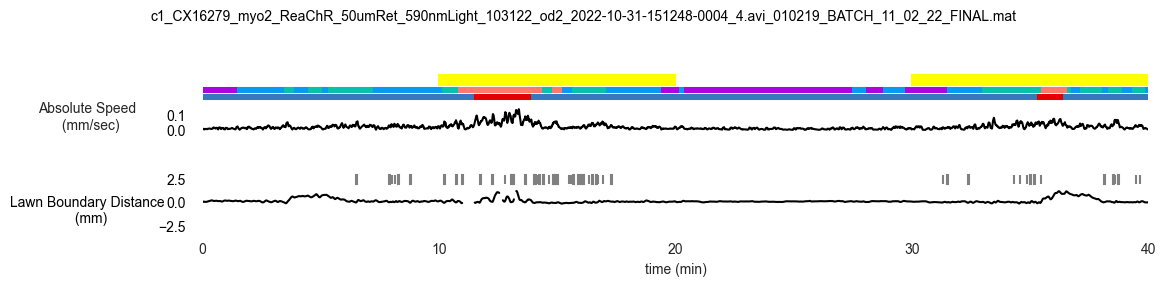

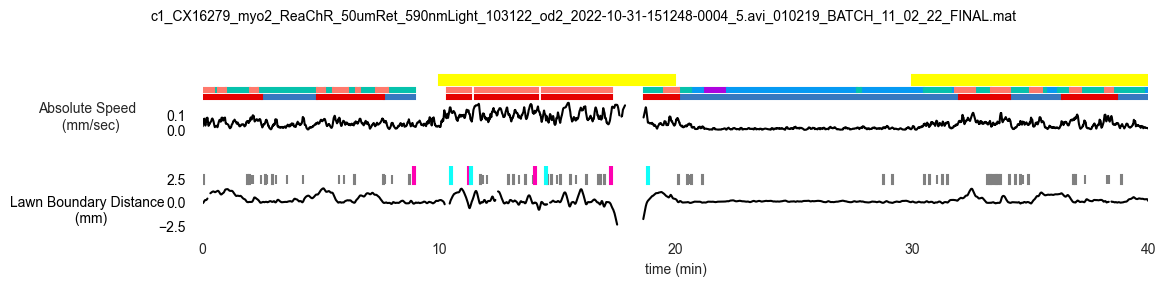

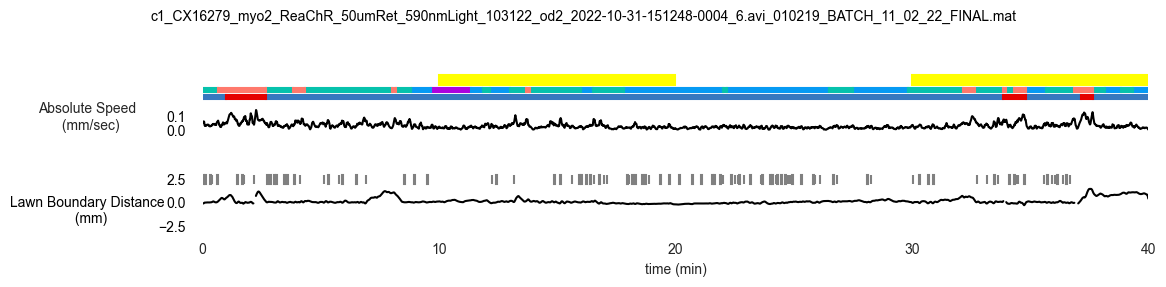

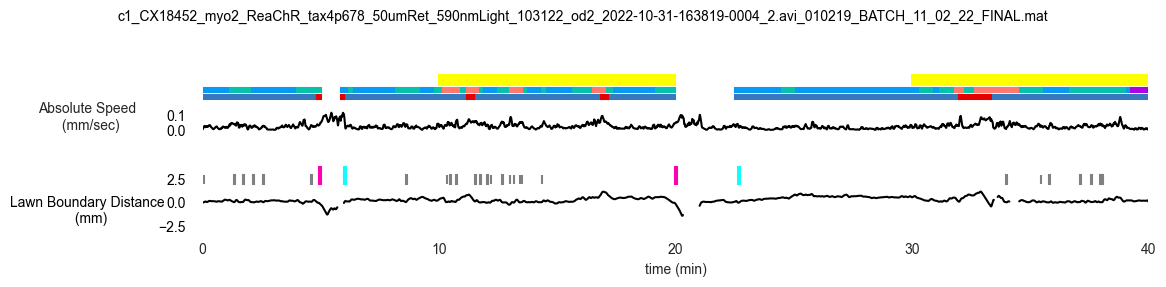

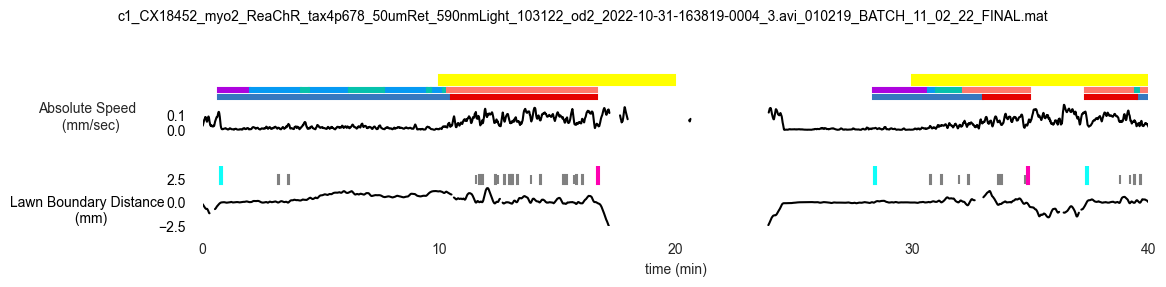

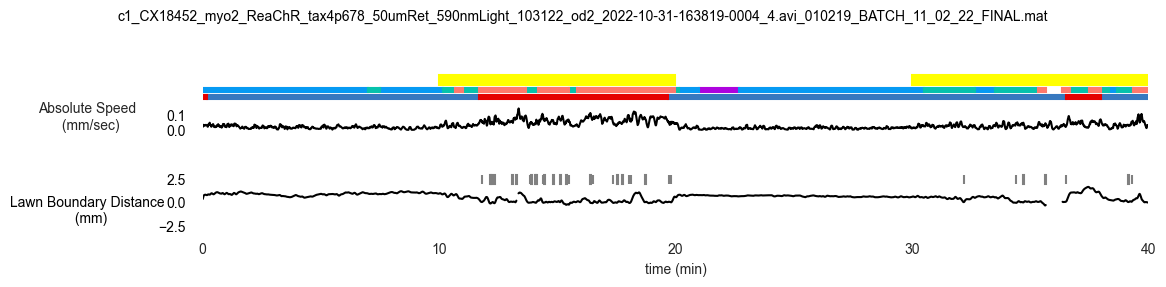

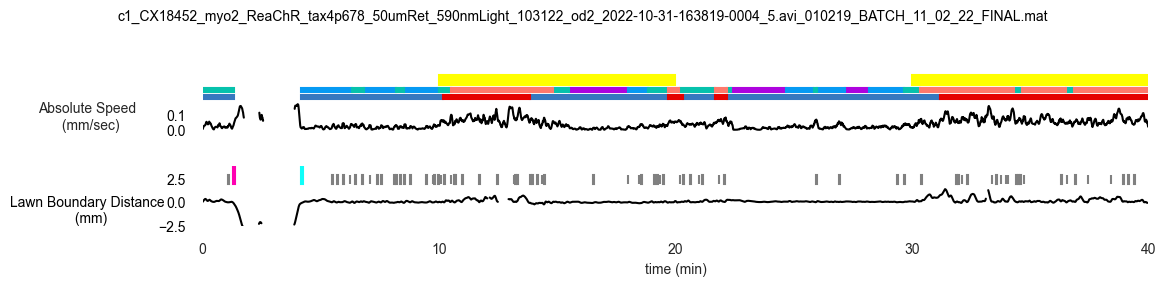

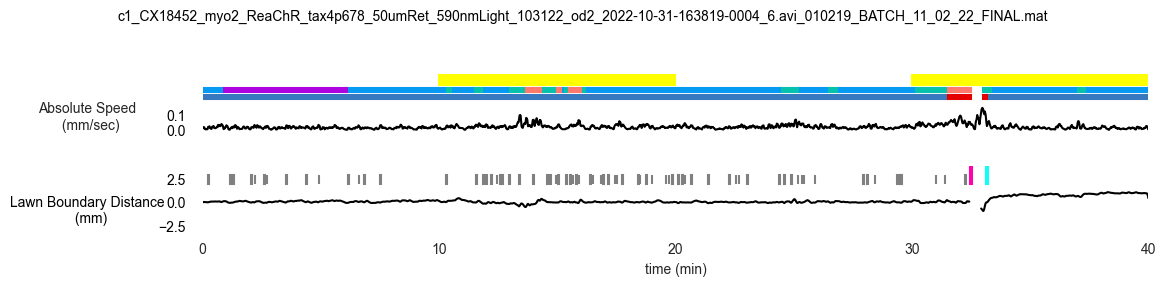

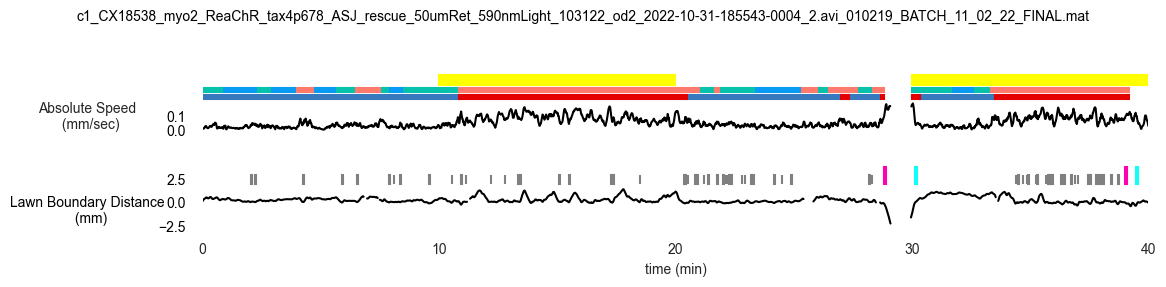

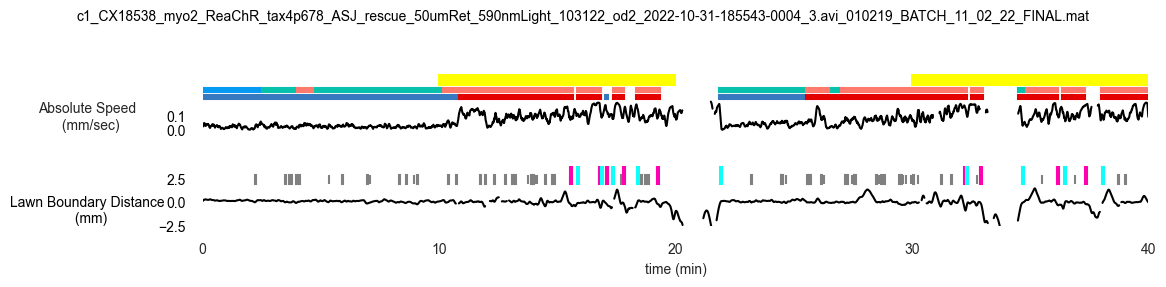

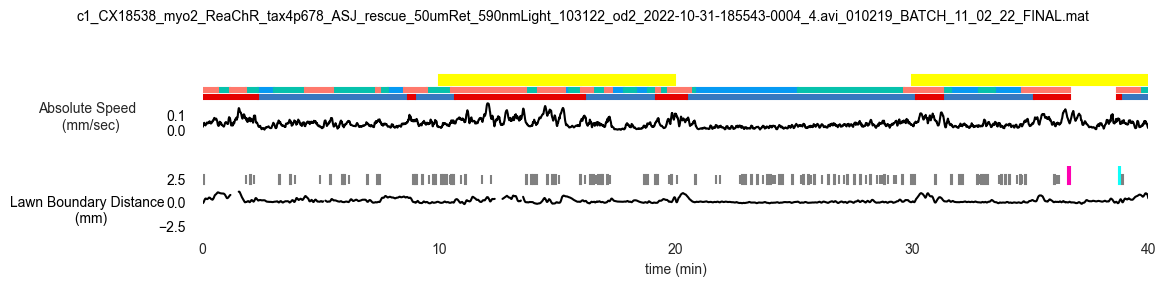

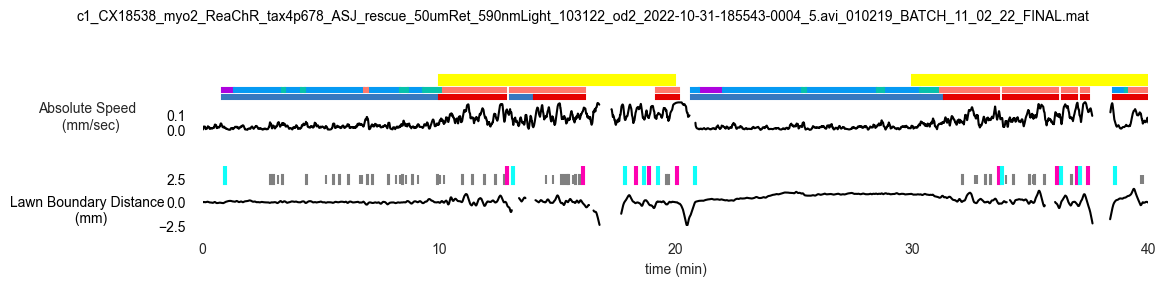

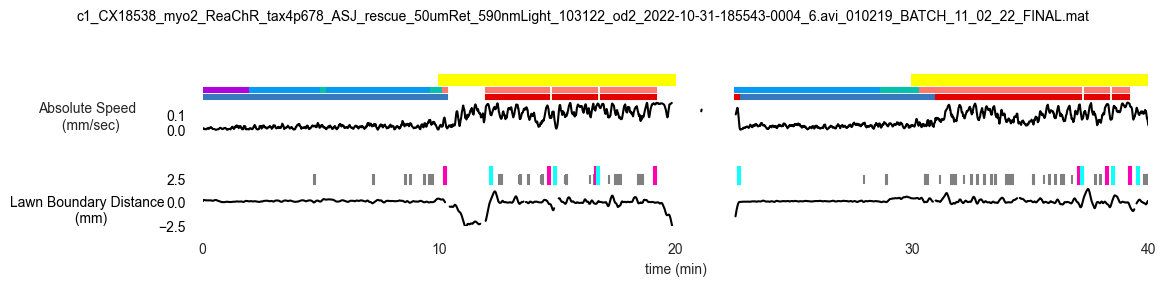

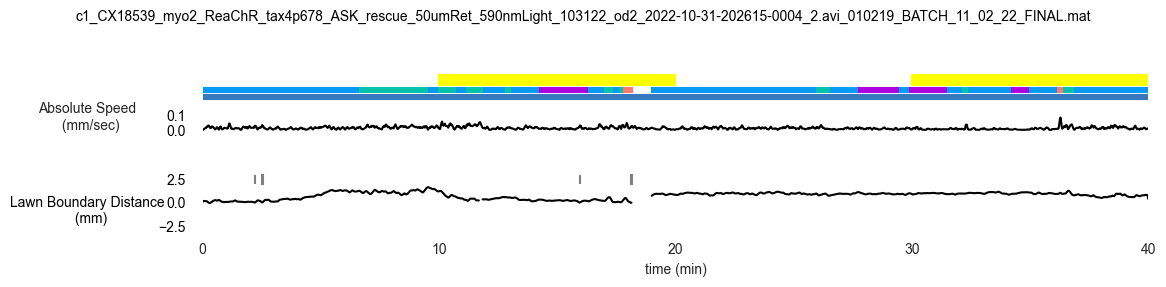

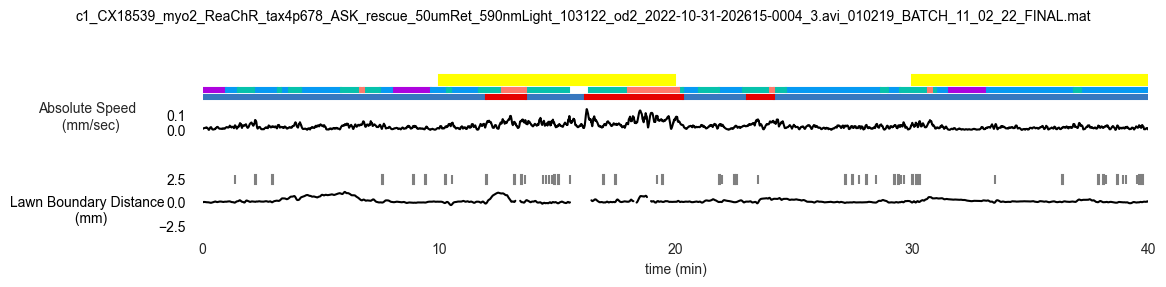

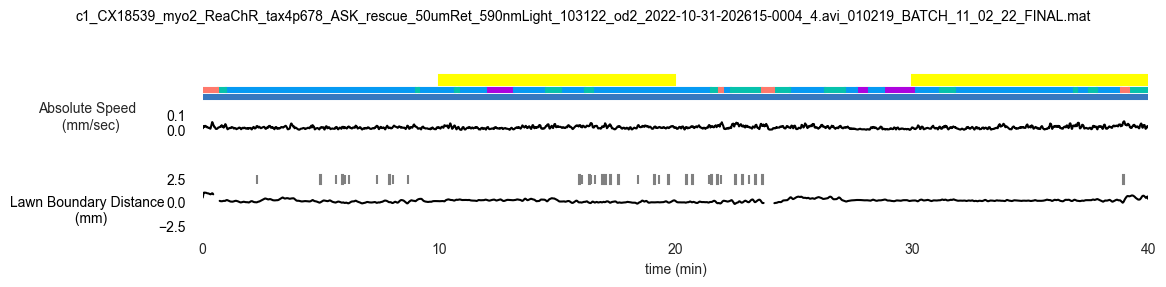

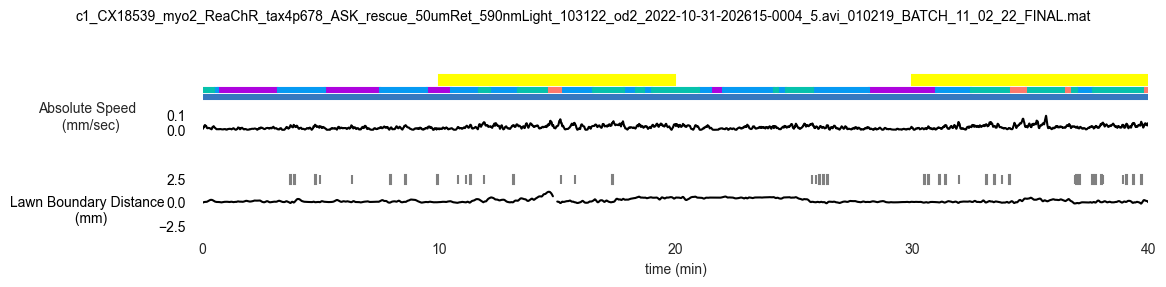

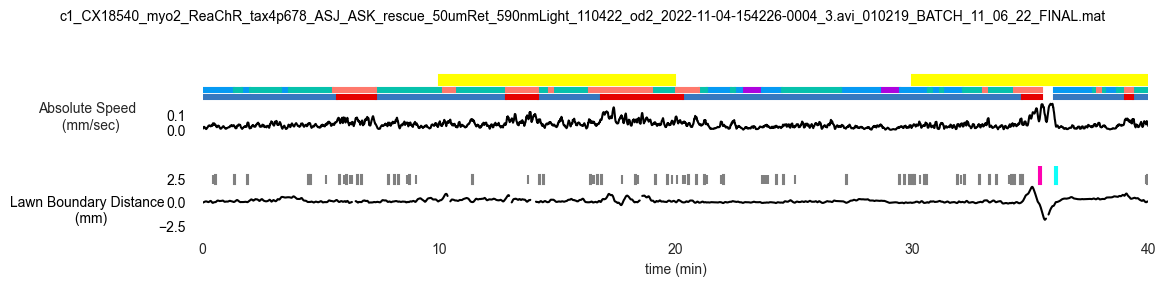

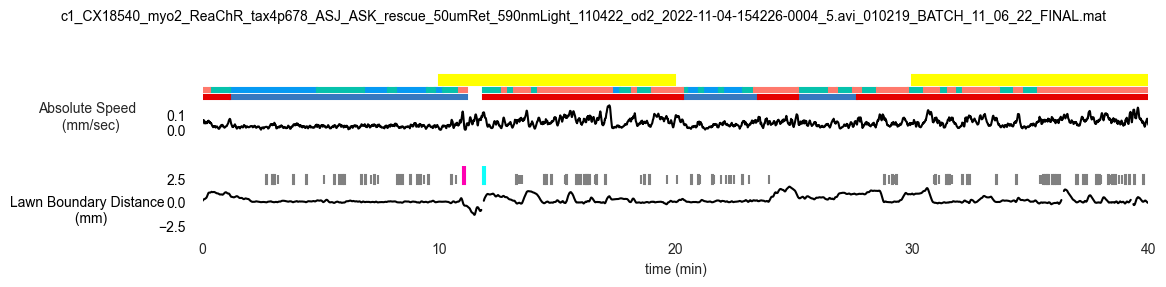

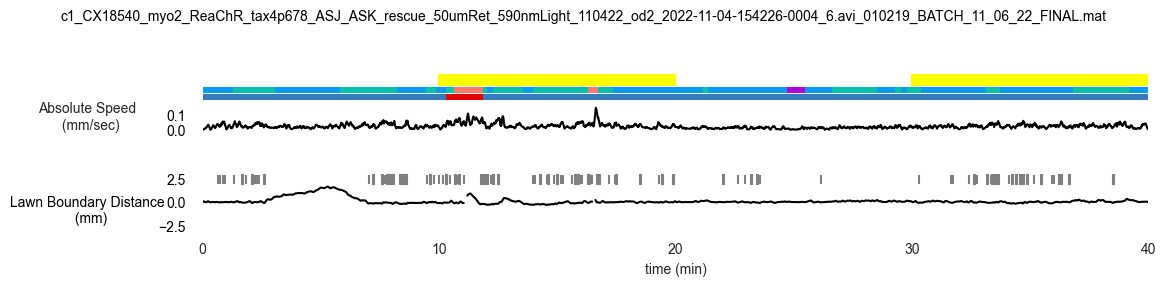

In [36]:
#Plot sample traces with state annotation

#show example track annotations of roaming and dwelling in UL and LL data
from matplotlib.patches import Rectangle

timeLine = np.linspace(0,40,7200)
xtickSpots = np.linspace(0,len(timeLine-1),5).astype(int)
xtickSpots[-1] = xtickSpots[-1]-1
xtickLabels = np.round(timeLine[xtickSpots]).astype(int).astype(str)

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = 'single traces (state annotations)'
sub_subfolder = os.path.join(subfolder,folderName)
if not os.path.exists(sub_subfolder):
    os.makedirs(sub_subfolder)

# randomIdx = np.random.choice(np.arange(len(Data['matfilename'])),20,replace=False)
# randomIdx = [1,10,500,1000]

for d_key,Data in Data_subs.items():
#     randomIdx = np.arange(Data['indexInAll'].shape[0]) #everybody
    randomIdx = [1,2,3,4,5]
    for idx in randomIdx:
        ################ Start with Centroid-related measurements
        Speed_midbody = movMean(abs(Data['Midbody_speed'][idx]),15)
        AngSpeed_midbody = (Data['Midbody_angspeed'][idx])
        RD_midbody = Data['RD_states_Matrix_exog'][idx].astype(int).filled(25).reshape(1,-1)
        RD_midbody = np.repeat(RD_midbody,binSize)

        Speed_cent = movMean(abs(Data['Centroid_speed'][idx]),15)
        AngSpeed_cent = (Data['Centroid_angspeed'][idx])
        RD_cent = Data['RD_states_Matrix_exog_Cent'][idx].astype(int).filled(25).reshape(1,-1)
        RD_cent = np.repeat(RD_cent,binSize)

        BacDensity_head = movMean(Data['Bacterial_Density'][idx],15)
        ML = Data['arHMM_MLstates'][idx].astype(int).filled(25).reshape(1,-1)
        ML = np.repeat(ML,binSize)

        fig, axs = plt.subplots(2,1,figsize=(12,3),sharex=True,frameon=False)

        axs[0].set_facecolor('w')
        startIdx = 0
        endIdx = 7200

        #plot RD bouts
        for i in range(RD_hmm_Cent_exog.K):
            stateIntervals = get_intervals(RD_cent==i,0)
            if stateIntervals.size>0:
                intLen = stateIntervals[:,1]-stateIntervals[:,0]
                for intV, intL in zip(stateIntervals,intLen):
                    axs[0].add_patch(Rectangle((intV[0], 0.22), intL, 0.03,edgecolor=colors[i], facecolor=colors[i])) 

        #plot arHMM bouts
        for i in range(arHMM_model.K):
            stateIntervals = get_intervals(ML==i,0)
            if stateIntervals.size>0:
                intLen = stateIntervals[:,1]-stateIntervals[:,0]
                for intV, intL in zip(stateIntervals,intLen):
                    axs[0].add_patch(Rectangle((intV[0], 0.27), intL, 0.03,edgecolor=arhmm_colors[i], facecolor=arhmm_colors[i])) 

        #plot LIGHT ON EPOCHS
        light_ints = get_intervals(LIGHT_STIM[0],1)
        if light_ints.size>0:
            intLen = light_ints[:,1]-light_ints[:,0]
            for intV, intL in zip(light_ints,intLen):
                axs[0].add_patch(Rectangle((intV[0], 0.32), intL, 0.07,edgecolor='yellow', facecolor='yellow')) 
        
        color='black'
        axs[0].grid(b=None)
        axs[0].plot(Speed_cent,color='k',lw=1.5)
        axs[0].set_xlim(0,np.where(~np.isnan(Speed_cent))[0].max())
        axs[0].set_yticks([0,0.1])
        axs[0].set_ylabel('Absolute Speed \n (mm/sec)',fontsize=10,rotation = 0)
        axs[0].yaxis.set_label_coords(-0.12,0.0)
        axs[0].tick_params(axis='y', labelcolor='k', labelsize=10)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['bottom'].set_visible(False)
        axs[0].spines['left'].set_visible(False)

        if not ('uniform' in genotypes or 'UL' in genotypes):
            LawnBoundDist = movMean(Data['Lawn_Boundary_Dist'][idx],15)
            HeadpokeRev = Data['HeadPokeRev'][idx]
            Lawn_Exit = Data['Lawn_Exit'][idx]
            Lawn_Entry = Data['Lawn_Entry'][idx]
            hprIdx = np.where(HeadpokeRev)[0]
            axs[1].set_facecolor('w')
            color = 'black'

            axs[1].grid(b=None)
            axs[1].plot(LawnBoundDist, color='k',lw=1.5)
            axs[1].set_ylim([-2.5,4])
            axs[1].tick_params(axis='y', labelcolor='k', labelsize=10)
            axs[1].set_ylabel('Lawn Boundary Distance \n (mm)',color=color, fontsize=10, rotation = 0) # we already handled the x-label with ax1
            axs[1].yaxis.set_label_coords(-0.12,0.0)

            hprIdx = np.where(HeadpokeRev)[0]
            for h in hprIdx:
                axs[1].add_patch(Rectangle((h, 2), 5, 1,edgecolor='gray', facecolor='gray'))
            
            exitIdx = np.where(Lawn_Exit)[0]
            for e in exitIdx:
                axs[1].add_patch(Rectangle((e, 2), 15, 2,edgecolor=colors[10], facecolor=colors[10])) 
            
            entryIdx = np.where(Lawn_Entry)[0]
            for e in entryIdx:
                axs[1].add_patch(Rectangle((e, 2), 15, 2,edgecolor=colors[11], facecolor=colors[11]))

            axs[1].set_xlabel('time (min)')
            axs[1].set_xticks(xtickSpots)
            axs[1].set_xticklabels(xtickLabels)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['right'].set_visible(False)
            axs[1].spines['bottom'].set_visible(False)
            axs[1].spines['left'].set_visible(False)
    

        plt.suptitle(Data['matfilename'].iloc[idx][0],fontsize=10)
        if saveFigures:
            outpath = os.path.join(sub_subfolder,Data['matfilename'].iloc[idx][0][:-4]+'.pdf')
            plt.savefig(outpath)#,dpi=300)